In [131]:
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime as dt
import statsmodels.formula.api as sm
import warnings 
import itertools
import time

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve, auc

In [132]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 8,5

In [133]:
warnings.filterwarnings('ignore')

In [134]:
#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

# Description of Variables

- Age: The age of the employee. (Numerical)
- Attrition: Whether or not the employee has left the organization. (Categorical)
- BusinessTravel: The frequency of business travel for the employee. (Categorical)
- DailyRate: The daily rate of pay for the employee. (Numerical)
- Department: The department the employee works in. (Categorical)
- DistanceFromHome: The distance from home in miles for the employee. (Numerical)
- Education: The level of education achieved by the employee. (Categorical)
- EducationField: The field of study for the employee's education. (Categorical)
- EmployeeCount: The total number of employees in the organization. (Numerical)
- EmployeeNumber: A unique identifier for each employee profile. (Numerical)
- EnvironmentSatisfaction: The employee's satisfaction with their work environment. (Categorical)
- Gender: The gender of the employee. (Categorical)
- HourlyRate: The hourly rate of pay for the employee. (Numerical)
- JobInvolvement: The level of involvement required for the employee's job. (Categorical)
- JobLevel: The job level of the employee. (Categorical)
- JobRole: The role of the employee in the organization. (Categorical)
- JobSatisfaction: The employee's satisfaction with their job. (Categorical)
- MaritalStatus: The marital status of the employee. (Categorical)
- MonthlyIncome: The monthly income of the employee. (Numerical)
- MonthlyRate: The monthly rate of pay for the employee. (Numerical)
- NumCompaniesWorked: The number of companies the employee has worked for. (Numerical)
- Over18: Whether or not the employee is over 18. (Categorical)
- OverTime: Whether or not the employee works overtime. (Categorical)
- PercentSalaryHike: The percentage of salary hike for the employee. (Numerical)
- PerformanceRating: The performance rating of the employee. (Categorical)
- RelationshipSatisfaction: The employee's satisfaction with their relationships. (Categorical)
- StandardHours: The standard hours of work for the employee. (Numerical)
- StockOptionLevel: The stock option level of the employee. (Numerical)
- TotalWorkingYears: The total number of years the employee has worked. (Numerical)
- TrainingTimesLastYear: The number of times the employee was taken for training in the last year. (Numerical)
- WorkLifeBalance: The employee's perception of their work-life balance. (Categorical)
- YearsAtCompany: The number of years the employee has been with the company. (Numerical)
- YearsInCurrentRole: The number of years the employee has been in their current role. (Numerical)
- YearsSinceLastPromotion: The number of years since the employee's last promotion. (Numerical)
- YearsWithCurrManager: The number of years the employee has been with their current manager. (Numerical)

In [267]:
#Load data
df=pd.read_csv("data/HR_Analytics.csv")
df = pd.get_dummies(df, columns = ["Attrition"])
df.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_No,Attrition_Yes
0,41,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,...,0,8,0,1,6,4,0,5,0,1
1,49,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,...,1,10,3,3,10,7,1,7,1,0
2,37,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,...,0,7,3,3,0,0,0,0,0,1
3,33,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,...,0,8,3,3,8,7,3,0,1,0
4,27,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,...,1,6,3,3,2,2,2,2,1,0


In [268]:
#Keep the dummy column where employees leaving = 1, because there are far less of them and we want to minimize FNR and recall
df = df.drop(["Attrition_No"], axis = 1)

In [269]:
#Drop employee count, over 18 and standard hours because they are the same value for every person
df = df.drop(["EmployeeCount", "StandardHours", "Over18"], axis = 1)
df.columns

Index(['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Attrition_Yes'],
      dtype='object')

In [270]:
#Splitting up data into train and test data - train has 70% of values and test has 30%
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=25)

print(f"No. of training examples: {train.shape[0]}")
print(f"No. of testing examples: {test.shape[0]}")


No. of training examples: 1029
No. of testing examples: 441


In [271]:
#Printing the ratio of No's and Yes's to the response variable (Attrition) for train and test to make sure they are similar
print(train.Attrition_Yes.value_counts()[1]/train.Attrition_Yes.value_counts()[0])
print(test.Attrition_Yes.value_counts()[1]/test.Attrition_Yes.value_counts()[0])

0.1937354988399072
0.18867924528301888


In [272]:
#There are zero missing values that need to be filled in either data set
print(train.isna().sum().sum())
print(test.isna().sum().sum())

0
0


In [273]:
train.columns

Index(['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Attrition_Yes'],
      dtype='object')

In [274]:
#df = df.drop(['JobRole', 'EducationField'], axis = 1)
#df.columns

In [275]:
# separate the target variable and predictor variables
X = df.drop(columns = ['Attrition_Yes'], axis=1)
y = df['Attrition_Yes']

In [276]:
X = X.rename(columns=lambda x: x.strip())

X = pd.get_dummies(X, drop_first = True)
X.columns = X.columns.str.replace('-', '')
X.columns = X.columns.str.replace(' ', '')
X.columns = X.columns.str.replace('&', '_')

X

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_LaboratoryTechnician,JobRole_Manager,JobRole_ManufacturingDirector,JobRole_ResearchDirector,JobRole_ResearchScientist,JobRole_SalesExecutive,JobRole_SalesRepresentative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,1102,1,2,1,2,94,3,2,4,...,0,0,0,0,0,1,0,0,1,1
1,49,279,8,1,2,3,61,2,2,2,...,0,0,0,0,1,0,0,1,0,0
2,37,1373,2,2,4,4,92,2,1,3,...,1,0,0,0,0,0,0,0,1,1
3,33,1392,3,4,5,4,56,3,1,3,...,0,0,0,0,1,0,0,1,0,1
4,27,591,2,1,7,1,40,3,1,2,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,884,23,2,2061,3,41,4,2,4,...,1,0,0,0,0,0,0,1,0,0
1466,39,613,6,1,2062,4,42,2,3,1,...,0,0,0,0,0,0,0,1,0,0
1467,27,155,4,3,2064,2,87,4,2,2,...,0,0,1,0,0,0,0,1,0,1
1468,49,1023,2,3,2065,4,63,2,2,2,...,0,0,0,0,0,1,0,1,0,0


In [277]:
test = test.rename(columns=lambda x: x.strip())

test = pd.get_dummies(test, drop_first = True)
test.columns = test.columns.str.replace('-', '')
test.columns = test.columns.str.replace(' ', '')
test.columns = test.columns.str.replace('&', '_')

test = pd.get_dummies(test, drop_first = True)
test.shape
test

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_LaboratoryTechnician,JobRole_Manager,JobRole_ManufacturingDirector,JobRole_ResearchDirector,JobRole_ResearchScientist,JobRole_SalesExecutive,JobRole_SalesRepresentative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
942,36,325,10,4,1312,4,63,3,3,3,...,0,0,0,0,0,0,0,1,0,0
415,34,296,6,2,555,4,33,1,1,3,...,0,0,0,0,0,0,1,0,0,0
1259,30,305,16,3,1763,3,58,4,2,3,...,0,0,0,0,0,0,0,1,0,0
466,41,1276,2,5,625,2,91,3,4,1,...,0,1,0,0,0,0,0,1,0,0
424,57,210,29,3,568,1,56,2,4,4,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,42,933,19,3,752,3,57,4,1,3,...,0,0,0,0,1,0,0,0,0,1
1292,39,766,20,3,1812,3,83,3,2,4,...,0,0,0,0,0,1,0,0,0,0
1186,35,880,12,4,1667,4,36,3,2,4,...,0,0,0,0,0,1,0,0,1,1
37,35,890,2,3,49,4,97,3,1,4,...,0,0,0,0,0,0,1,1,0,0


In [278]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# perform oversampling on the training data
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# print the number of examples in each class before and after oversampling
print("Before oversampling:")
print(y_train.value_counts())
print("After oversampling:")
print(y_train_resampled.value_counts())

Before oversampling:
0    978
1    198
Name: Attrition_Yes, dtype: int64
After oversampling:
0    978
1    978
Name: Attrition_Yes, dtype: int64


In [279]:
y_train_resampled.name = 'Attrition_Yes'

In [280]:
X_train_for_final = X_train_resampled.copy()

# Checking VIF, dropping variables with VIF>10 1-by-1

In [281]:
# check for multicolinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
Var = X_train_resampled[X_train_resampled.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data.sort_values(by = 'VIF', ascending = False))

                             feature         VIF
0                              const  596.631312
27   Department_Research_Development   74.028887
28                  Department_Sales   71.743775
29       EducationField_LifeSciences   22.107487
41            JobRole_SalesExecutive   19.540439
31            EducationField_Medical   19.528226
11                     MonthlyIncome   18.192908
9                           JobLevel   15.426832
35            JobRole_HumanResources   13.695804
42       JobRole_SalesRepresentative   11.529331
30          EducationField_Marketing   10.306761
33    EducationField_TechnicalDegree    9.639126
32              EducationField_Other    6.449830
18                 TotalWorkingYears    5.441899
21                    YearsAtCompany    5.201672
36      JobRole_LaboratoryTechnician    4.797671
40         JobRole_ResearchScientist    4.698941
37                   JobRole_Manager    4.004965
44              MaritalStatus_Single    3.473892
25  BusinessTravel_T

In [282]:
# Drop the feature with the greatest VIF (Department_Research_Development)
col_to_drop = ["Department_Research_Development"]
X_train_resampled = X_train_resampled.drop(col_to_drop, axis=1)

In [283]:
#Retesting VIF without Department_Research_Development
Var = X_train_resampled[X_train_resampled.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data.sort_values(by = 'VIF', ascending = False))

                             feature         VIF
0                              const  354.460687
27                  Department_Sales   20.592159
28       EducationField_LifeSciences   20.532974
40            JobRole_SalesExecutive   18.395549
11                     MonthlyIncome   18.184693
30            EducationField_Medical   18.057217
9                           JobLevel   15.418660
41       JobRole_SalesRepresentative   10.886817
29          EducationField_Marketing    9.622908
32    EducationField_TechnicalDegree    8.992469
31              EducationField_Other    6.030837
18                 TotalWorkingYears    5.423582
21                    YearsAtCompany    5.188710
35      JobRole_LaboratoryTechnician    4.793356
39         JobRole_ResearchScientist    4.696008
36                   JobRole_Manager    3.738700
43              MaritalStatus_Single    3.471571
25  BusinessTravel_Travel_Frequently    3.193948
26      BusinessTravel_Travel_Rarely    3.185846
22                Ye

In [284]:
# Drop the feature with the greatest VIF (Department_Sales)
col_to_drop = ["Department_Sales"]
X_train_resampled = X_train_resampled.drop(col_to_drop, axis=1)

In [285]:
#Retesting VIF without Department_Sales
Var = X_train_resampled[X_train_resampled.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data.sort_values(by = 'VIF', ascending = False))

                             feature         VIF
0                              const  354.426165
27       EducationField_LifeSciences   20.428186
11                     MonthlyIncome   18.153276
29            EducationField_Medical   18.010078
9                           JobLevel   15.413640
28          EducationField_Marketing    9.462002
31    EducationField_TechnicalDegree    8.954114
30              EducationField_Other    6.011849
18                 TotalWorkingYears    5.423571
21                    YearsAtCompany    5.129165
34      JobRole_LaboratoryTechnician    4.793317
38         JobRole_ResearchScientist    4.695848
39            JobRole_SalesExecutive    3.631283
42              MaritalStatus_Single    3.470554
40       JobRole_SalesRepresentative    3.244240
25  BusinessTravel_Travel_Frequently    3.192453
26      BusinessTravel_Travel_Rarely    3.180799
22                YearsInCurrentRole    3.113894
35                   JobRole_Manager    2.996785
24              Year

In [286]:
# Drop the feature with the greatest VIF (EducationField_LifeSciences)
col_to_drop = ["EducationField_LifeSciences"]
X_train_resampled = X_train_resampled.drop(col_to_drop, axis=1)

In [287]:
#Retesting VIF without EducationField_LifeSciences
Var = X_train_resampled[X_train_resampled.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data.sort_values(by = 'VIF', ascending = False))

                             feature         VIF
0                              const  275.768048
11                     MonthlyIncome   18.152727
9                           JobLevel   15.412618
18                 TotalWorkingYears    5.421276
21                    YearsAtCompany    5.124550
33      JobRole_LaboratoryTechnician    4.792109
37         JobRole_ResearchScientist    4.695754
38            JobRole_SalesExecutive    3.629282
41              MaritalStatus_Single    3.469939
39       JobRole_SalesRepresentative    3.243835
25  BusinessTravel_Travel_Frequently    3.192399
26      BusinessTravel_Travel_Rarely    3.177749
22                YearsInCurrentRole    3.113852
34                   JobRole_Manager    2.989830
24              YearsWithCurrManager    2.869454
14                 PercentSalaryHike    2.580235
15                 PerformanceRating    2.563067
36          JobRole_ResearchDirector    2.490149
1                                Age    2.192837
40             Marit

In [288]:
# Drop the feature with the greatest VIF (MonthlyIncome)
col_to_drop = ["MonthlyIncome"]
X_train_resampled = X_train_resampled.drop(col_to_drop, axis=1)

In [289]:
#Retesting VIF without MonthlyIncome
Var = X_train_resampled[X_train_resampled.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data.sort_values(by = 'VIF', ascending = False))

                             feature         VIF
0                              const  275.492166
9                           JobLevel    7.017367
17                 TotalWorkingYears    5.337605
20                    YearsAtCompany    5.121160
32      JobRole_LaboratoryTechnician    4.763061
36         JobRole_ResearchScientist    4.683020
37            JobRole_SalesExecutive    3.625779
40              MaritalStatus_Single    3.469835
38       JobRole_SalesRepresentative    3.203161
24  BusinessTravel_Travel_Frequently    3.189242
25      BusinessTravel_Travel_Rarely    3.171997
21                YearsInCurrentRole    3.113594
23              YearsWithCurrManager    2.852284
13                 PercentSalaryHike    2.578916
14                 PerformanceRating    2.559941
33                   JobRole_Manager    2.242877
1                                Age    2.191315
39             MaritalStatus_Married    2.153343
16                  StockOptionLevel    1.982880
34     JobRole_Manuf

In [290]:
# Making "train" a dataframe with the dummy variables, highly correlated variables dropped, and with the response
train = pd.concat([X_train_resampled, pd.DataFrame(y_train_resampled)],axis =1)

In [291]:
# Concating test with the response variable
test = pd.concat([X_test, pd.DataFrame(y_test)],axis =1)

# Baseline Model

In [292]:
#Logistic regression model with all predictors - baseline model
column_list = train.columns.to_list()[:-1] #not including Attrition
formula = 'Attrition_Yes~'+'+'.join(column_list)

logit_model = smf.logit(formula=formula, data=train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.429967
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Attrition_Yes   No. Observations:                 1956
Model:                          Logit   Df Residuals:                     1914
Method:                           MLE   Df Model:                           41
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.3797
Time:                        10:14:37   Log-Likelihood:                -841.02
converged:                       True   LL-Null:                       -1355.8
Covariance Type:            nonrobust   LLR p-value:                3.929e-189
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.9725      1.039      0.936      0.349      -1.063       3.008
Age                                 -0.0196      0.009     -2.075      0.038      -0.038      -0.001
DailyRate                           -0.0002      0.000     -1.381      0.167      -0.001    9.35e-05
DistanceFromHome                     0.0416      0.008      5.253      0.000       0.026       0.057
Education                            0.0385      0.062      0.622      0.534      -0.083       0.160
EmployeeNumber                   -1.943e-05      0.000     -0.182      0.856      -0.000       0.000
EnvironmentSatisfaction             -0.3797      0.060     -6.308      0.000      -0.498      -0.262
HourlyRate                           0.0017      0.003      0.529      0.597      -0.005       0.008
JobInvolvement                      -0.4697      0.091     -5.164      0.000      -0.648      -0.291
JobLevel                             0.2208      0.161      1.368      0.171      -0.096       0.537
JobSatisfaction                     -0.3430      0.059     -5.826      0.000      -0.458      -0.228
MonthlyRate                       1.637e-05   8.86e-06      1.847      0.065      -1e-06    3.37e-05
NumCompaniesWorked                   0.1910      0.028      6.922      0.000       0.137       0.245
PercentSalaryHike                   -0.0491      0.027     -1.815      0.069      -0.102       0.004
PerformanceRating                   -0.0986      0.280     -0.353      0.724      -0.647       0.450
RelationshipSatisfaction            -0.1318      0.057     -2.307      0.021      -0.244      -0.020
StockOptionLevel                    -0.1489      0.101     -1.471      0.141      -0.347       0.050
TotalWorkingYears                   -0.0855      0.020     -4.286      0.000      -0.125      -0.046
TrainingTimesLastYear               -0.1464      0.049     -2.979      0.003      -0.243      -0.050
WorkLifeBalance                     -0.4767      0.088     -5.420      0.000      -0.649      -0.304
YearsAtCompany                       0.1870      0.024      7.870      0.000       0.140       0.234
YearsInCurrentRole                  -0.1993      0.033     -6.121      0.000      -0.263      -0.135
YearsSinceLastPromotion              0.1320      0.028      4.738      0.000       0.077       0.187
YearsWithCurrManager                -0.1497      0.030     -4.993      0.000      -0.209      -0.091
BusinessTravel_Travel_Frequently     1.7815      0.282      6.308      0.000       1.228       2.335
BusinessTravel_Travel_Rarely         1.0784      0.257      4.190      0.000       0.574       1.583
EducationField_Marketing             0.1489      0.248      0.601      0.548      -0.337       0.634
EducationField_Medical               0.2453      0.149      1.643      0.100      -0.047       0.538
EducationField_Other                 0.6779      0.265      2.556      0.011       0.158       1.198
Education

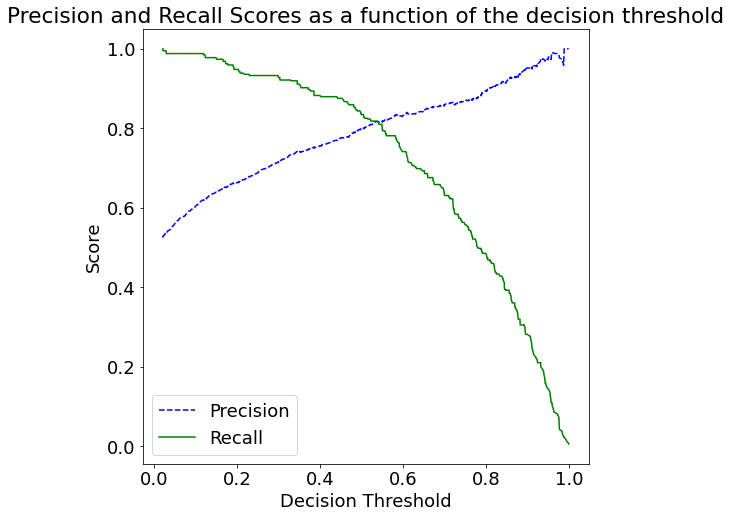

In [293]:
from sklearn.metrics import precision_recall_curve
y=train.Attrition_Yes
ypred = logit_model.predict(train)
p, r, thresholds = precision_recall_curve(y, ypred)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

Classification accuracy = 79.6%
Precision = 83.2%
TPR or Recall = 74.1%
FNR = 25.9%
FPR = 14.9%
ROC-AUC = 88.3%


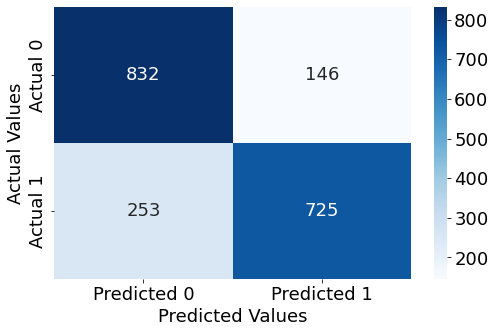

In [294]:
confusion_matrix_data(train,train.Attrition_Yes,logit_model,0.6)

Classification accuracy = 77.2%
Precision = 29.4%
TPR or Recall = 51.3%
FNR = 48.7%
FPR = 18.8%
ROC-AUC = 76.5%


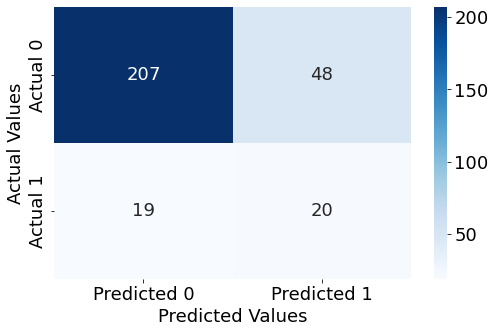

In [295]:
confusion_matrix_data(test,test.Attrition_Yes,logit_model,0.6)

0.8830027475629493


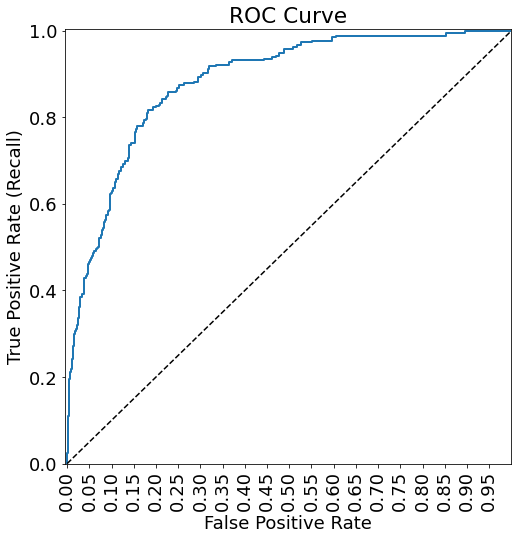

In [296]:
from sklearn.metrics import roc_curve, auc
y=train.Attrition_Yes
ypred = logit_model.predict(train)
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

fpr, tpr, auc_thresholds = roc_curve(y, ypred)
plot_roc_curve(fpr, tpr)

# Visualizing Transformations

Text(0.5, 1.0, 'Attrition Percent based on Job Level')

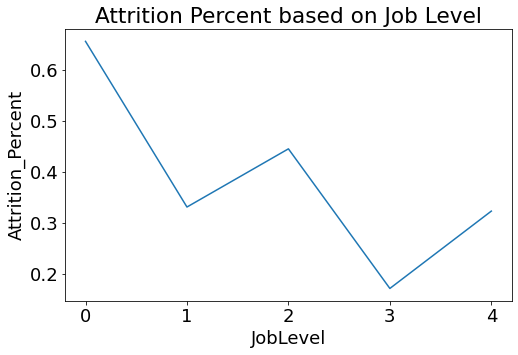

In [297]:
JobLevel_data = train.groupby('JobLevel')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = JobLevel_data.index, y= JobLevel_data['Attrition_Percent'])
plt.xlabel('JobLevel')
plt.title("Attrition Percent based on Job Level")

Text(0.5, 1.0, 'Attrition Percent based on TotalWorkingYears')

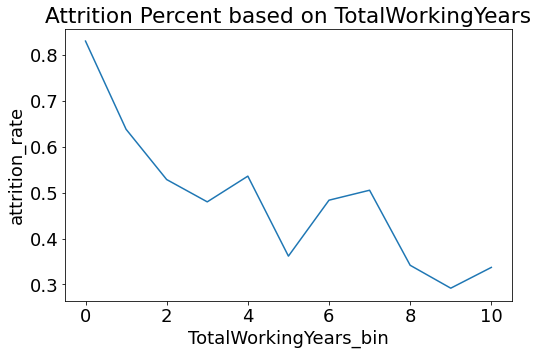

In [298]:
binned_workingyears = pd.qcut(train['TotalWorkingYears'],11,retbins=True)
train['workingyears_binned'] = binned_workingyears[0]
workingyears_data = train.groupby('workingyears_binned')['Attrition_Yes'].agg([('attrition_rate','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = workingyears_data.index, y= workingyears_data['attrition_rate'])
plt.xlabel('TotalWorkingYears_bin')
plt.title("Attrition Percent based on TotalWorkingYears")

Text(0.5, 1.0, 'Attrition Percent based on YearsAtCompany')

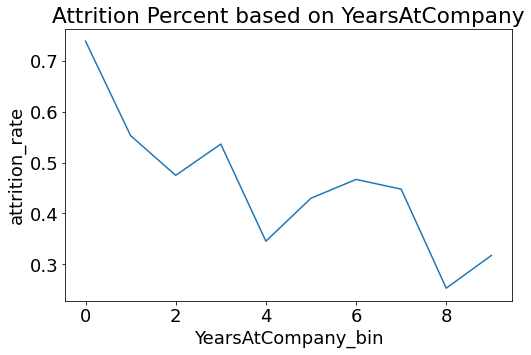

In [299]:
binned_company = pd.qcut(train['YearsAtCompany'],11,retbins=True, duplicates="drop")
train['company_binned'] = binned_company[0]
company_data = train.groupby('company_binned')['Attrition_Yes'].agg([('attrition_rate','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = company_data.index, y= company_data['attrition_rate'])
plt.xlabel('YearsAtCompany_bin')
plt.title("Attrition Percent based on YearsAtCompany")

Text(0.5, 1.0, 'Attrition Percent based on YearsInCurrentRole')

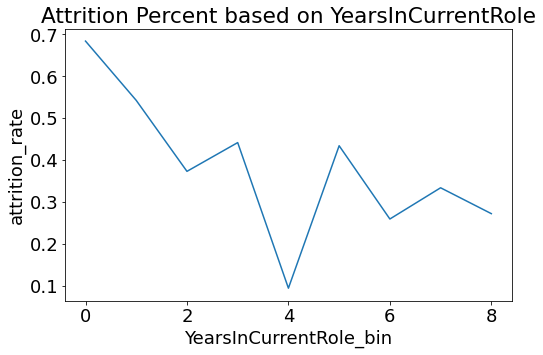

In [300]:
binned_YearsInCurrentRole = pd.qcut(train['YearsInCurrentRole'],20,retbins=True, duplicates="drop")
train['YearsInCurrentRole_binned'] = binned_YearsInCurrentRole[0]
YearsInCurrentRole_data = train.groupby('YearsInCurrentRole_binned')['Attrition_Yes'].agg([('attrition_rate','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = YearsInCurrentRole_data.index, y= YearsInCurrentRole_data['attrition_rate'])
plt.xlabel('YearsInCurrentRole_bin')
plt.title("Attrition Percent based on YearsInCurrentRole")

Text(0.5, 1.0, 'Attrition Percent based on YearsWithCurrManager')

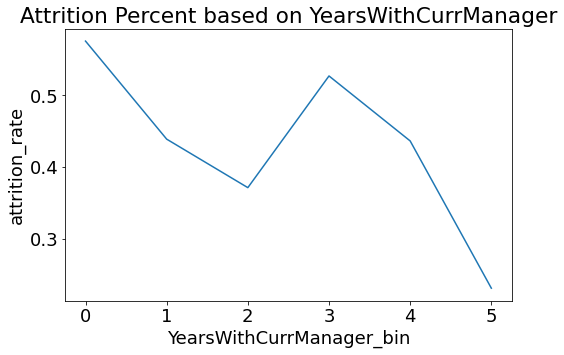

In [301]:
binned_YearsWithCurrManager = pd.qcut(train['YearsWithCurrManager'],10,retbins=True, duplicates="drop")
train['YearsWithCurrManager_binned'] = binned_YearsWithCurrManager[0]
YearsWithCurrManager_data = train.groupby('YearsWithCurrManager_binned')['Attrition_Yes'].agg([('attrition_rate','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = YearsWithCurrManager_data.index, y= YearsWithCurrManager_data['attrition_rate'])
plt.xlabel('YearsWithCurrManager_bin')
plt.title("Attrition Percent based on YearsWithCurrManager")

Text(0.5, 1.0, 'Attrition Percent based on PercentSalaryHike')

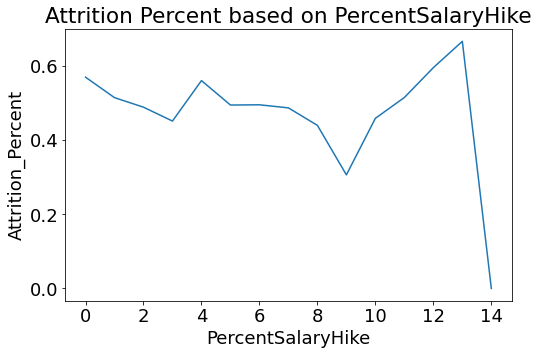

In [302]:
PercentSalaryHike_data = train.groupby('PercentSalaryHike')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = PercentSalaryHike_data.index, y= PercentSalaryHike_data['Attrition_Percent'])
plt.xlabel('PercentSalaryHike')
plt.title("Attrition Percent based on PercentSalaryHike")

Text(0.5, 1.0, 'Attrition Percent based on Age')

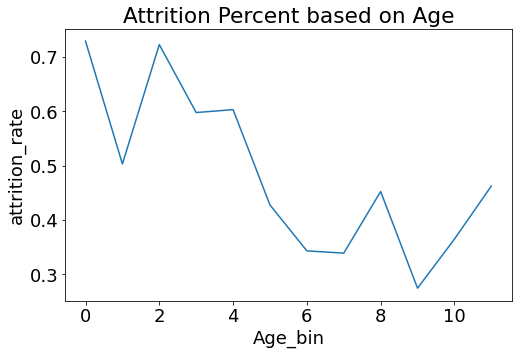

In [303]:
binned_age = pd.qcut(train['Age'],12,retbins=True)
train['age_binned'] = binned_age[0]
age_data = train.groupby('age_binned')['Attrition_Yes'].agg([('attrition_rate','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = age_data.index, y= age_data['attrition_rate'])
plt.xlabel('Age_bin')
plt.title("Attrition Percent based on Age")

Text(0.5, 1.0, 'Attrition Percent based on Stock Option Level')

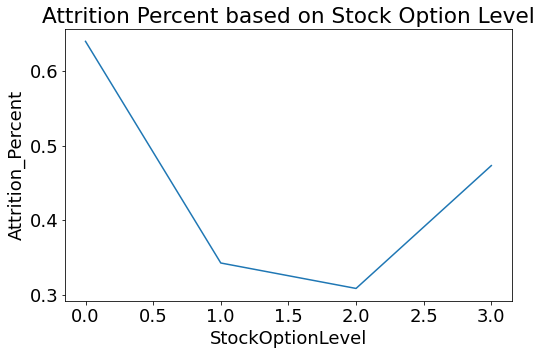

In [304]:
Stock_data = train.groupby('StockOptionLevel')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Stock_data.index, y= Stock_data['Attrition_Percent'])
plt.xlabel('StockOptionLevel')
plt.title("Attrition Percent based on Stock Option Level")

Text(0.5, 1.0, 'Attrition Percent based on YearsSinceLastPromotion')

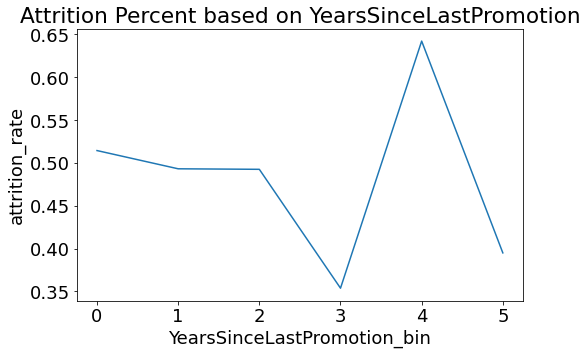

In [305]:
binned_YearsSinceLastPromotion = pd.qcut(train['YearsSinceLastPromotion'],15,retbins=True, duplicates="drop")
train['YearsSinceLastPromotion_binned'] = binned_YearsSinceLastPromotion[0]
YearsSinceLastPromotion_data = train.groupby('YearsSinceLastPromotion_binned')['Attrition_Yes'].agg([('attrition_rate','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = YearsSinceLastPromotion_data.index, y= YearsSinceLastPromotion_data['attrition_rate'])
plt.xlabel('YearsSinceLastPromotion_bin')
plt.title("Attrition Percent based on YearsSinceLastPromotion")

Text(0.5, 1.0, 'Attrition Percent based on Number of Companies Worked')

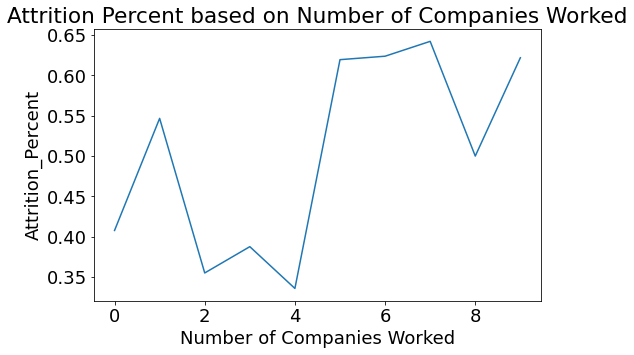

In [306]:
NumCompaniesWorked_data = train.groupby('NumCompaniesWorked')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = NumCompaniesWorked_data.index, y= NumCompaniesWorked_data['Attrition_Percent'])
plt.xlabel('Number of Companies Worked')
plt.title("Attrition Percent based on Number of Companies Worked")

Text(0.5, 1.0, 'Attrition Percent based on Education Level')

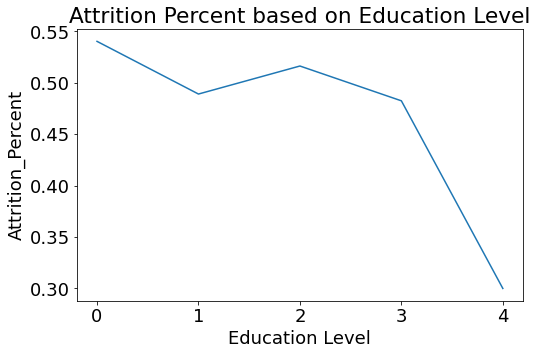

In [307]:
Education_data = train.groupby('Education')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = Education_data.index, y= Education_data['Attrition_Percent'])
plt.xlabel('Education Level')
plt.title("Attrition Percent based on Education Level")

Text(0.5, 1.0, 'Attrition Percent based on WorkLifeBalance')

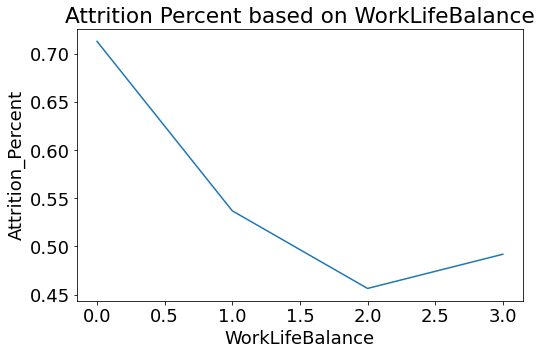

In [308]:
WorkLifeBalance_data = train.groupby('WorkLifeBalance')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = WorkLifeBalance_data.index, y= WorkLifeBalance_data['Attrition_Percent'])
plt.xlabel('WorkLifeBalance')
plt.title("Attrition Percent based on WorkLifeBalance")

Text(0.5, 1.0, 'Attrition Percent based on MonthlyRate')

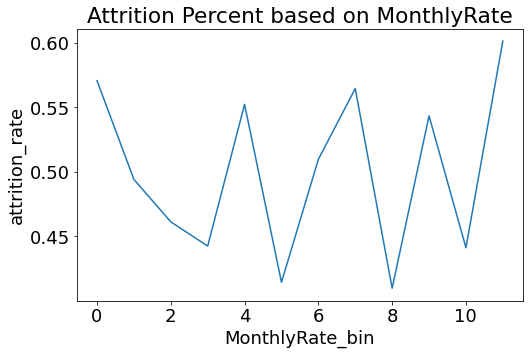

In [309]:
binned_MonthlyRate = pd.qcut(train['MonthlyRate'],12,retbins=True)
train['MonthlyRate_binned'] = binned_MonthlyRate[0]
MonthlyRate_data = train.groupby('MonthlyRate_binned')['Attrition_Yes'].agg([('attrition_rate','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = MonthlyRate_data.index, y= MonthlyRate_data['attrition_rate'])
plt.xlabel('MonthlyRate_bin')
plt.title("Attrition Percent based on MonthlyRate")

Text(0.5, 1.0, 'Attrition Percent based on DistanceFromHome')

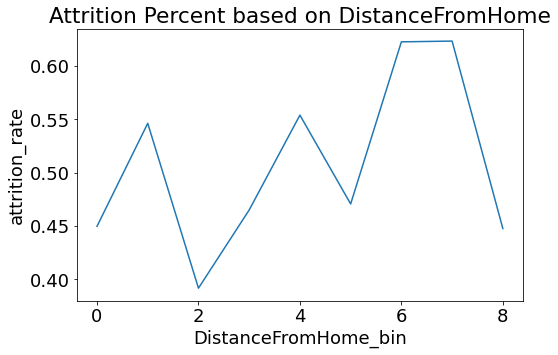

In [310]:
binned_distance = pd.qcut(train['DistanceFromHome'],10,retbins=True, duplicates="drop")
train['distance_binned'] = binned_distance[0]
distance_data = train.groupby('distance_binned')['Attrition_Yes'].agg([('attrition_rate','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = distance_data.index, y= distance_data['attrition_rate'])
plt.xlabel('DistanceFromHome_bin')
plt.title("Attrition Percent based on DistanceFromHome")

Text(0.5, 1.0, 'Attrition Percent based on DailyRate')

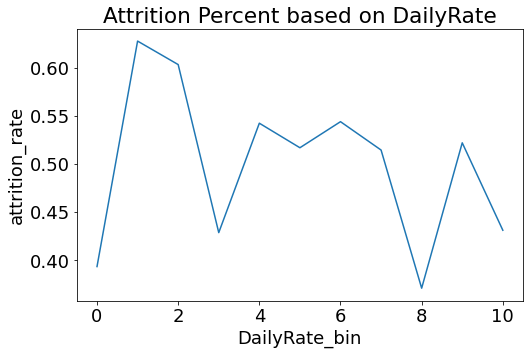

In [311]:
binned_DailyRate = pd.qcut(train['DailyRate'],11,retbins=True)
train['DailyRate_binned'] = binned_DailyRate[0]
DailyRate_data = train.groupby('DailyRate_binned')['Attrition_Yes'].agg([('attrition_rate','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = DailyRate_data.index, y= DailyRate_data['attrition_rate'])
plt.xlabel('DailyRate_bin')
plt.title("Attrition Percent based on DailyRate")

Text(0.5, 1.0, 'Attrition Percent based on JobSatisfaction')

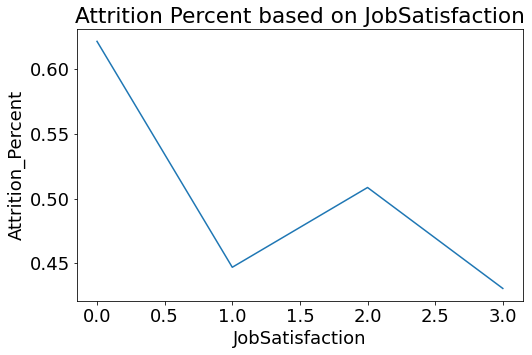

In [312]:
JobSatisfaction_data = train.groupby('JobSatisfaction')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = JobSatisfaction_data.index, y= JobSatisfaction_data['Attrition_Percent'])
plt.xlabel('JobSatisfaction')
plt.title("Attrition Percent based on JobSatisfaction")

Text(0.5, 1.0, 'Attrition Percent based on EnvironmentSatisfaction')

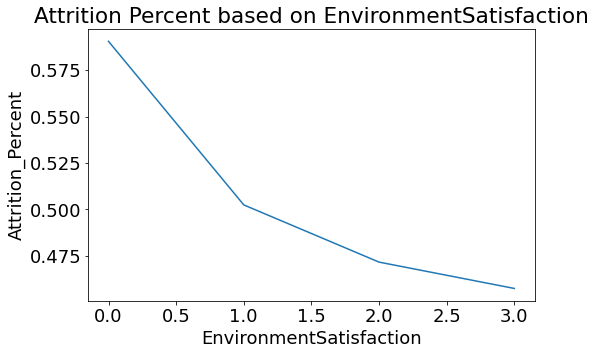

In [313]:
EnvironmentSatisfaction_data = train.groupby('EnvironmentSatisfaction')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = EnvironmentSatisfaction_data.index, y= EnvironmentSatisfaction_data['Attrition_Percent'])
plt.xlabel('EnvironmentSatisfaction')
plt.title("Attrition Percent based on EnvironmentSatisfaction")

Text(0.5, 1.0, 'Attrition Percent based on RelationshipSatisfaction')

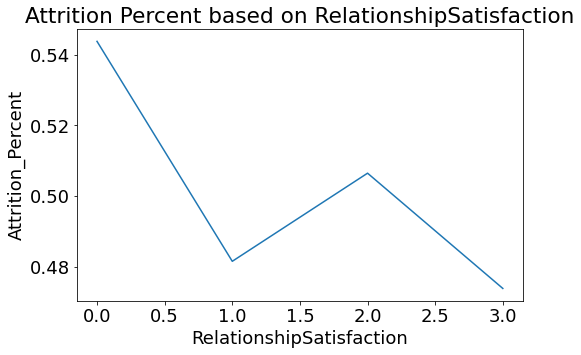

In [314]:
RelationshipSatisfaction_data = train.groupby('RelationshipSatisfaction')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = RelationshipSatisfaction_data.index, y= RelationshipSatisfaction_data['Attrition_Percent'])
plt.xlabel('RelationshipSatisfaction')
plt.title("Attrition Percent based on RelationshipSatisfaction")

Text(0.5, 1.0, 'Attrition Percent based on TrainingTimesLastYear')

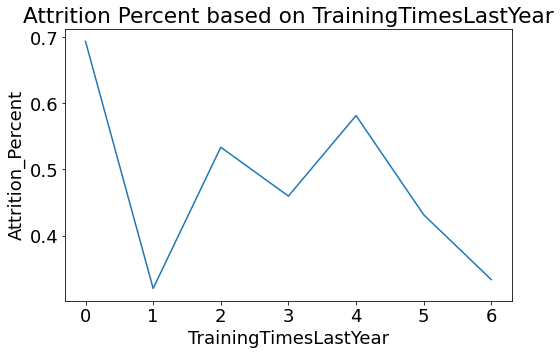

In [315]:
TrainingTimesLastYear_data = train.groupby('TrainingTimesLastYear')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = TrainingTimesLastYear_data.index, y= TrainingTimesLastYear_data['Attrition_Percent'])
plt.xlabel('TrainingTimesLastYear')
plt.title("Attrition Percent based on TrainingTimesLastYear")

Text(0.5, 1.0, 'Attrition Percent based on JobInvolvement')

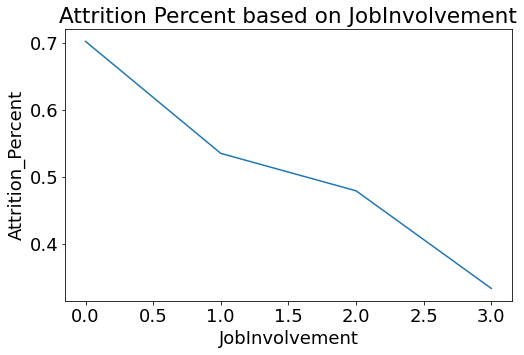

In [316]:
JobInvolvement_data = train.groupby('JobInvolvement')['Attrition_Yes'].agg([('Attrition_Percent','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = JobInvolvement_data.index, y= JobInvolvement_data['Attrition_Percent'])
plt.xlabel('JobInvolvement')
plt.title("Attrition Percent based on JobInvolvement")

Text(0.5, 1.0, 'Attrition Percent based on HourlyRate')

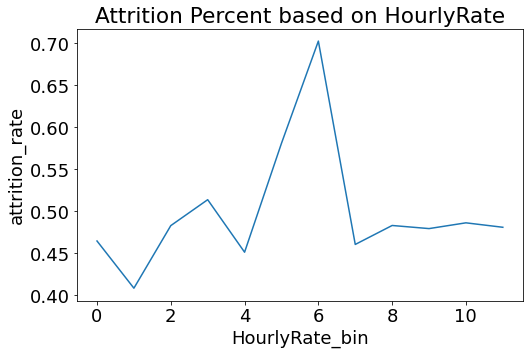

In [317]:
binned_HourlyRate = pd.qcut(train['HourlyRate'],12,retbins=True)
train['HourlyRate_binned'] = binned_HourlyRate[0]
HourlyRate_data = train.groupby('HourlyRate_binned')['Attrition_Yes'].agg([('attrition_rate','mean'),('count','count')]).reset_index(drop=False)
sns.lineplot(x = HourlyRate_data.index, y= HourlyRate_data['attrition_rate'])
plt.xlabel('HourlyRate_bin')
plt.title("Attrition Percent based on HourlyRate")

**Insights for Possible Transformations**

YearsInCurrentRole - quadratic

PercentSalaryHike - log

StockOptionLevel - quadratic

YearsSinceLastPromotion - quadratic

NumCompaniesWorked - quadratic

Education - log

WorkLifeBalance - log

DailyRate - quadratic

TrainingTimesLastYear - quadratic

HourlyRate - quadratic

# Adding Transformations to Dataframe

In [318]:
train = train.drop(columns = ['workingyears_binned', 'company_binned',
       'YearsInCurrentRole_binned', 'YearsWithCurrManager_binned',
       'age_binned', 'YearsSinceLastPromotion_binned', 'MonthlyRate_binned',
       'distance_binned', 'DailyRate_binned', 'HourlyRate_binned'])

In [319]:
train_transformations = train.copy()
train_singular = train_transformations.copy()

In [264]:
train_transformations[['YearsInCurrentRole_quadratic', 'StockOptionLevel_quadratic', 'YearsSinceLastPromotion_quadratic', 'DailyRate_quadratic', 'TrainingTimesLastYear_quadratic', 'HourlyRate_quadratic']] = train_transformations[['YearsInCurrentRole', 'StockOptionLevel', 'YearsSinceLastPromotion', 'DailyRate', 'TrainingTimesLastYear', 'HourlyRate']].apply(lambda x: x**2)
train_transformations[['PercentSalaryHike_log', 'Education_log', 'WorkLifeBalance_log']] = train_transformations[['PercentSalaryHike', 'Education', 'WorkLifeBalance']].apply(lambda x: np.log(x))

In [58]:
train_transformations

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,Attrition_Yes,YearsInCurrentRole_quadratic,StockOptionLevel_quadratic,YearsSinceLastPromotion_quadratic,DailyRate_quadratic,TrainingTimesLastYear_quadratic,HourlyRate_quadratic,PercentSalaryHike_log,Education_log,WorkLifeBalance_log
0,24,350,21,2,1551,3,57,2,1,1,...,0,1,9,0,122500,9,3249,2.639057,0.693147,1.098612
1,18,287,5,2,1012,2,73,3,1,4,...,0,0,0,0,82369,4,5329,2.708050,0.693147,1.098612
2,29,1247,20,2,349,4,45,3,2,4,...,0,4,1,0,1555009,4,2025,2.639057,0.693147,1.098612
3,39,492,12,3,1654,4,66,3,2,2,...,0,16,0,1,242064,9,4356,3.044522,1.098612,1.098612
4,31,311,20,3,1881,2,89,3,2,3,...,0,64,1,0,96721,4,7921,2.397895,1.098612,1.098612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,30,464,4,3,514,3,40,3,1,4,...,1,0,0,0,215296,16,1600,3.135494,1.098612,1.098612
1952,21,156,12,3,494,3,90,4,1,2,...,1,0,0,0,24336,0,8100,2.708050,1.098612,1.098612
1953,41,1356,20,2,248,2,70,3,1,2,...,1,9,0,0,1838736,25,4900,3.091042,0.693147,0.693147
1954,23,1243,6,3,811,3,63,4,1,1,...,1,0,4,0,1545049,4,3969,3.044522,1.098612,1.098612


# Forward Selection w/ transitions but without Interactions

In [59]:
#Creating a set of predictors from which we need to find the best subset of predictors
X = train_transformations.drop(columns = ["Attrition_Yes"])

In [60]:
#Function to develop a model based on all predictors in predictor_subset
train = train.apply(lambda x: x.str.strip() if isinstance(x.iloc[0], str) else x)
def processSubset(predictor_subset):
    if 'Attrition_Yes' in predictor_subset:
        predictor_subset = predictor_subset.remove('Attrition_Yes')

    logit_model = sm.logit(formula = 'Attrition_Yes~' + '+'.join(predictor_subset),data = train_transformations).fit() 
    llf = logit_model.llf
    return {"logit_model":logit_model, "Log-Likelihood":llf}

In [61]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Log-Likelihood'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [62]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Log-Likelihood", "logit_model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["logit_model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [63]:
models_best = forward_selection()

Optimization terminated successfully.
         Current function value: 0.671135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689421
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692107
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693004
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688763
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692620
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682307
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.658104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686367
  

Optimization terminated successfully.
         Current function value: 0.633553
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631809
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625025
         Iterations 5
Processed  49 models on 2 predictors in 0.34792518615722656 seconds.
Optimization terminated successfully.
         Current function value: 0.589536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602347
         Iterations 5
Optimization 

Optimization terminated successfully.
         Current function value: 0.576854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578844
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.576550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.569539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.578212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573376
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.576227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577579
  

Optimization terminated successfully.
         Current function value: 0.555325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.555721
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.554008
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.558381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.558654
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.558839
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.558831
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.556312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.557665
  

Optimization terminated successfully.
         Current function value: 0.542279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.542345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.542656
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.542857
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.540612
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.541599
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.541393
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.542897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.540304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.541328
  

Optimization terminated successfully.
         Current function value: 0.520878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.522405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.521457
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519621
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.525427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.525724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.526298
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.526108
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.524873
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.524963
  

Optimization terminated successfully.
         Current function value: 0.513949
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.513738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.512093
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.512733
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.513601
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.513982
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511966
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.513524
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511428
  

Optimization terminated successfully.
         Current function value: 0.493862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494466
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495132
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492449
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495243
         Iterations 6
Processed  37 models on 14 predictors in 0.6933441162109375 seconds.
Optimization terminated successfully.
         Current function value: 0.489479
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490139
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486210
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490827
         Iterations 6
Optimization 

Optimization terminated successfully.
         Current function value: 0.476149
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475849
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475159
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473913
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476263
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.473660
  

Optimization terminated successfully.
         Current function value: 0.461891
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.464413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464934
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465087
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460955
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.463884
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.463081
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460927
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.464774
  

Optimization terminated successfully.
         Current function value: 0.453833
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.452921
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.451107
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.452029
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453090
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453030
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.451829
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453864
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.450836
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453493
  

Optimization terminated successfully.
         Current function value: 0.444913
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.444932
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.444898
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443773
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.444916
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.444921
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443717
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.444196
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.442537
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.444927
  

Optimization terminated successfully.
         Current function value: 0.436695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436987
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.437907
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.437747
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.437881
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436871
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435038
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436974
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.437453
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435306
  

Optimization terminated successfully.
         Current function value: 0.425943
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.424958
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.425961
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.425930
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.425305
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.425918
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426016
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.425530
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.424815
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426025
  

Optimization terminated successfully.
         Current function value: 0.420683
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421508
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421502
         Iterations 7
Processed  15 models on 36 predictors in 0.6417419910430908 seconds.
Optimization terminated successfully.
         Current function value: 0.420203
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420312
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420656
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420594
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420522
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420564
         Iterations 7
Optimization 

Optimization terminated successfully.
         Current function value: 0.412636
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412657
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412551
         Iterations 7
Processed  8 models on 43 predictors in 0.3521599769592285 seconds.
Optimization terminated successfully.
         Current function value: 0.412341
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412424
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412366
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412414
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412399
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412412
         Iterations 7
Optimization t

In [64]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Log-Likelihood"])
    plt.xlabel('# Predictors')
    plt.ylabel('Log-Likelihood')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    """
    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('psuedo rsquared')
    """

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

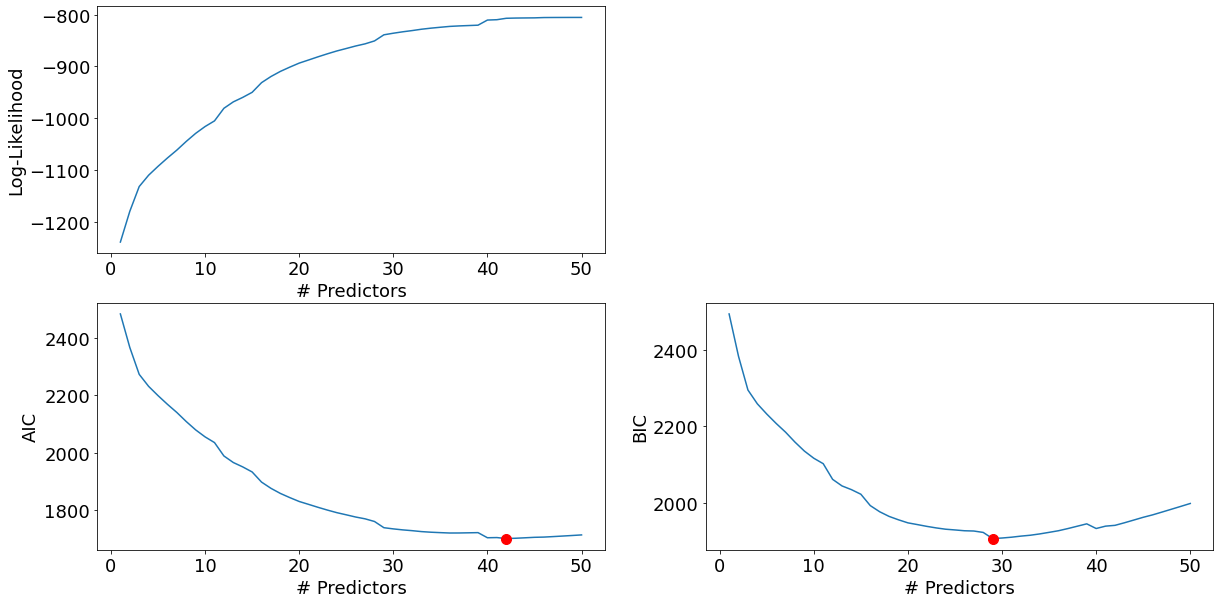

In [65]:
best_sub_plots()

In [66]:
singular_fwd_reg_model = models_best['logit_model'][29]
singular_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Attrition_Yes   No. Observations:                 1956
Model:                          Logit   Df Residuals:                     1926
Method:                           MLE   Df Model:                           29
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.3811
Time:                        02:56:21   Log-Likelihood:                -839.10
converged:                       True   LL-Null:                       -1355.8
Covariance Type:            nonrobust   LLR p-value:                7.580e-199
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             2.6250      1.021      2.571      0.010       0.624       4.626
OverTime_Yes                          2.0456      0.137     14.965      0.000       1.778       2.314
MaritalStatus_Single                  1.9438      0.187     10.370      0.000       1.576       2.311
JobLevel                              0.1351      0.144      0.938      0.348      -0.147       0.418
JobInvolvement                       -0.5173      0.089     -5.788      0.000      -0.693      -0.342
JobRole_ResearchScientist             0.5297      0.279      1.895      0.058      -0.018       1.077
EducationField_TechnicalDegree        1.4998      0.210      7.145      0.000       1.088       1.911
EnvironmentSatisfaction              -0.3446      0.059     -5.877      0.000      -0.459      -0.230
WorkLifeBalance_log                  -1.1774      0.196     -6.007      0.000      -1.562      -0.793
JobSatisfaction                      -0.3362      0.057     -5.918      0.000      -0.447      -0.225
BusinessTravel_Travel_Frequently      1.8902      0.282      6.704      0.000       1.338       2.443
YearsSinceLastPromotion_quadratic    -0.0051      0.005     -0.953      0.341      -0.016       0.005
YearsInCurrentRole                   -0.4811      0.061     -7.902      0.000      -0.600      -0.362
YearsInCurrentRole_quadratic          0.0254      0.004      5.833      0.000       0.017       0.034
YearsAtCompany                        0.1839      0.025      7.435      0.000       0.135       0.232
NumCompaniesWorked                    0.1746      0.027      6.388      0.000       0.121       0.228
TotalWorkingYears                    -0.1103      0.018     -6.033      0.000      -0.146      -0.074
DistanceFromHome                      0.0466      0.008      5.952      0.000       0.031       0.062
BusinessTravel_Travel_Rarely          1.1473      0.256      4.480      0.000       0.645       1.649
MaritalStatus_Married                 0.7355      0.175      4.192      0.000       0.392       1.079
JobRole_ResearchDirector             -1.7271      0.546     -3.161      0.002      -2.798      -0.656
YearsWithCurrManager                 -0.1090      0.031     -3.475      0.001      -0.170      -0.048
Gender_Male                           0.4572      0.129      3.537      0.000       0.204       0.711
PercentSalaryHike_log                -0.9299      0.282     -3.297      0.001      -1.483      -0.377
YearsSinceLastPromotion               0.1674      0.061      2.739      0.006       0.048       0.287
JobRole_SalesRepresentative           2.1763      0.335      6.498      0.000       1.520       2.833
TrainingTimesLastYear                -0.1416      0.049     -2.873      0.004      -0.238      -0.045
JobRole_LaboratoryTechnician          1.6246      0.276      5.894      0.000       1.084       2.165
JobRole_HumanResources                1.7945      0.369      4.862      0.000  

# Creating Interactions

In [67]:
train = train.drop(['JobRole_HumanResources', 'JobRole_LaboratoryTechnician', 'JobRole_Manager', 'JobRole_ManufacturingDirector', 'JobRole_ResearchDirector', 'JobRole_SalesExecutive', 'JobRole_SalesRepresentative', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other'], axis = 1)

In [68]:
X_train_resampled = train.drop(columns = ["Attrition_Yes"])

In [69]:
import itertools

X_backup = X_train_resampled.copy()
interactions = pd.DataFrame()

for combo in itertools.combinations(X_backup.columns, 2):
    prefix1 = combo[0][:combo[0].rfind('_')].split('_')[0]
    prefix2 = combo[1][:combo[1].rfind('_')].split('_')[0]
    if prefix1 != prefix2:
        train['_'.join(combo)] = train[combo[0]]*train[combo[1]]
        test['_'.join(combo)] = test[combo[0]]*test[combo[1]]
        X_train_resampled.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)] 
        interactions.loc[:,'_'.join(combo)] = X_train_resampled.loc[:,'_'.join(combo)]
        #only make interaction terms if the prefix(before the last underscore) of combo[0] is not the same as that of of combo[1]
        # Add the other code here under the if condition

In [70]:
interactions

,Age_DailyRate,Age_DistanceFromHome,Age_Education,Age_EmployeeNumber,Age_EnvironmentSatisfaction,Age_HourlyRate,Age_JobInvolvement,Age_JobLevel,Age_JobSatisfaction,Age_MonthlyRate,...,EducationField_TechnicalDegree_OverTime_Yes,Gender_Male_JobRole_ResearchScientist,Gender_Male_MaritalStatus_Married,Gender_Male_MaritalStatus_Single,Gender_Male_OverTime_Yes,JobRole_ResearchScientist_MaritalStatus_Married,JobRole_ResearchScientist_MaritalStatus_Single,JobRole_ResearchScientist_OverTime_Yes,MaritalStatus_Married_OverTime_Yes,MaritalStatus_Single_OverTime_Yes
0,8400,504,48,37224,72,1368,48,24,24,240864,...,0,0,0,0,0,0,0,0,0,0
1,5166,90,36,18216,36,1314,54,18,72,242874,...,0,1,0,1,0,0,1,0,0,0
2,36163,580,58,10121,116,1305,87,58,116,311228,...,0,0,0,0,0,0,0,0,0,0
3,19188,468,117,64506,156,2574,117,78,78,300027,...,0,0,1,0,0,0,0,0,0,0
4,9641,620,93,58311,62,2759,93,62,93,577344,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,13920,120,90,15420,90,1200,90,30,120,102810,...,1,1,0,1,1,0,1,1,0,1
1952,3276,252,63,10374,63,1890,84,21,42,533862,...,0,0,0,0,0,0,0,0,0,0
1953,55596,820,82,10168,82,2870,123,41,82,890848,...,0,0,0,0,0,0,0,0,0,1
1954,28589,138,69,18653,69,1449,92,23,23,79235,...,0,0,1,0,1,0,0,0,1,0


# Dropping Interaction Terms with High VIF

In [71]:
#Testing VIF of interaction terms
Var = interactions[interactions.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data.sort_values(by = 'VIF', ascending = False))

                                            feature          VIF
318                PerformanceRating_YearsAtCompany  1814.917085
19                               Age_YearsAtCompany  1656.091668
315             PerformanceRating_TotalWorkingYears  1266.321963
319            PerformanceRating_YearsInCurrentRole   949.085758
323  PerformanceRating_BusinessTravel_Travel_Rarely   928.126742
..                                              ...          ...
84       DistanceFromHome_JobRole_ResearchScientist     6.882450
458                        Gender_Male_OverTime_Yes     6.815711
461          JobRole_ResearchScientist_OverTime_Yes     5.931504
454     EducationField_TechnicalDegree_OverTime_Yes     4.812246
359           StockOptionLevel_MaritalStatus_Single          NaN

[464 rows x 2 columns]


In [72]:
#Making a list of all null VIF values and values greater than 500
vif_null = vif_data[(vif_data.VIF.isnull()) | (vif_data.VIF > 500)]
vif_null=vif_null.feature.to_list()

In [73]:
#Dropping null values and values greater than 500
interactions = interactions.drop(vif_null, axis=1)
interactions

,Age_DailyRate,Age_DistanceFromHome,Age_Education,Age_EmployeeNumber,Age_EnvironmentSatisfaction,Age_HourlyRate,Age_JobInvolvement,Age_JobLevel,Age_JobSatisfaction,Age_MonthlyRate,...,EducationField_TechnicalDegree_OverTime_Yes,Gender_Male_JobRole_ResearchScientist,Gender_Male_MaritalStatus_Married,Gender_Male_MaritalStatus_Single,Gender_Male_OverTime_Yes,JobRole_ResearchScientist_MaritalStatus_Married,JobRole_ResearchScientist_MaritalStatus_Single,JobRole_ResearchScientist_OverTime_Yes,MaritalStatus_Married_OverTime_Yes,MaritalStatus_Single_OverTime_Yes
0,8400,504,48,37224,72,1368,48,24,24,240864,...,0,0,0,0,0,0,0,0,0,0
1,5166,90,36,18216,36,1314,54,18,72,242874,...,0,1,0,1,0,0,1,0,0,0
2,36163,580,58,10121,116,1305,87,58,116,311228,...,0,0,0,0,0,0,0,0,0,0
3,19188,468,117,64506,156,2574,117,78,78,300027,...,0,0,1,0,0,0,0,0,0,0
4,9641,620,93,58311,62,2759,93,62,93,577344,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,13920,120,90,15420,90,1200,90,30,120,102810,...,1,1,0,1,1,0,1,1,0,1
1952,3276,252,63,10374,63,1890,84,21,42,533862,...,0,0,0,0,0,0,0,0,0,0
1953,55596,820,82,10168,82,2870,123,41,82,890848,...,0,0,0,0,0,0,0,0,0,1
1954,28589,138,69,18653,69,1449,92,23,23,79235,...,0,0,1,0,1,0,0,0,1,0


In [74]:
#Retesting VIF without null and greater than 500 VIFs
Var = interactions[interactions.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data.sort_values(by = 'VIF', ascending = False))

                                              feature         VIF
312  PerformanceRating_EducationField_TechnicalDegree  425.240627
8                                        Age_JobLevel  359.371464
15                              Age_TotalWorkingYears  311.987273
311                 PerformanceRating_WorkLifeBalance  287.070765
316                    PerformanceRating_OverTime_Yes  284.329895
..                                                ...         ...
440             Gender_Male_JobRole_ResearchScientist    7.361499
81         DistanceFromHome_JobRole_ResearchScientist    6.702290
443                          Gender_Male_OverTime_Yes    6.674143
446            JobRole_ResearchScientist_OverTime_Yes    5.781480
439       EducationField_TechnicalDegree_OverTime_Yes    4.731910

[449 rows x 2 columns]


In [75]:
#Making a list of all VIF values greater than 100
vif_over_100 = vif_data[(vif_data["VIF"] > 100) & (vif_data["feature"] != "const")]
vif_over_100=vif_over_100.feature.to_list()

In [76]:
#Dropping values greater than 200
interactions = interactions.drop(vif_over_100, axis=1)
interactions

,Age_DailyRate,Age_DistanceFromHome,Age_EmployeeNumber,Age_EnvironmentSatisfaction,Age_JobSatisfaction,Age_MonthlyRate,Age_NumCompaniesWorked,Age_RelationshipSatisfaction,Age_TrainingTimesLastYear,Age_EducationField_TechnicalDegree,...,EducationField_TechnicalDegree_OverTime_Yes,Gender_Male_JobRole_ResearchScientist,Gender_Male_MaritalStatus_Married,Gender_Male_MaritalStatus_Single,Gender_Male_OverTime_Yes,JobRole_ResearchScientist_MaritalStatus_Married,JobRole_ResearchScientist_MaritalStatus_Single,JobRole_ResearchScientist_OverTime_Yes,MaritalStatus_Married_OverTime_Yes,MaritalStatus_Single_OverTime_Yes
0,8400,504,37224,72,24,240864,0,48,72,24,...,0,0,0,0,0,0,0,0,0,0
1,5166,90,18216,36,72,242874,18,72,36,0,...,0,1,0,1,0,0,1,0,0,0
2,36163,580,10121,116,116,311228,58,116,58,0,...,0,0,0,0,0,0,0,0,0,0
3,19188,468,64506,156,78,300027,156,117,117,0,...,0,0,1,0,0,0,0,0,0,0
4,9641,620,58311,62,93,577344,31,31,62,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,13920,120,15420,90,120,102810,270,90,120,30,...,1,1,0,1,1,0,1,1,0,1
1952,3276,252,10374,63,42,533862,21,84,0,0,...,0,0,0,0,0,0,0,0,0,0
1953,55596,820,10168,82,82,890848,41,164,205,0,...,0,0,0,0,0,0,0,0,0,1
1954,28589,138,18653,69,23,79235,23,69,46,0,...,0,0,1,0,1,0,0,0,1,0


In [77]:
#Retesting VIF without VIFs greater than 100
Var = interactions[interactions.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)
    
print(vif_data.sort_values(by = 'VIF', ascending = False))

                                               feature        VIF
10                  Age_EducationField_TechnicalDegree  81.312706
302               WorkLifeBalance_MaritalStatus_Single  72.924641
172                JobInvolvement_MaritalStatus_Single  68.151991
156                    HourlyRate_MaritalStatus_Single  67.393186
297       WorkLifeBalance_BusinessTravel_Travel_Rarely  67.210086
..                                                 ...        ...
358                           Gender_Male_OverTime_Yes   5.842021
351  EducationField_TechnicalDegree_JobRole_Researc...   5.729450
64          DistanceFromHome_JobRole_ResearchScientist   5.562903
361             JobRole_ResearchScientist_OverTime_Yes   5.050002
354        EducationField_TechnicalDegree_OverTime_Yes   3.821837

[364 rows x 2 columns]


In [78]:
#Making a list of all VIF values greater than 40
vif_over_40 = vif_data[(vif_data["VIF"] > 40) & (vif_data["feature"] != "const")]
vif_over_40=vif_over_40.feature.to_list()

In [79]:
#Dropping values greater than 40
interactions = interactions.drop(vif_over_40, axis=1)

In [80]:
#Retesting VIF without VIFs greater than 40
Var = interactions[interactions.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)
    
print(vif_data.sort_values(by = 'VIF', ascending = False))

                                               feature        VIF
0                                                const  53.047148
133      JobInvolvement_EducationField_TechnicalDegree  35.306399
206      RelationshipSatisfaction_MaritalStatus_Single  32.772959
244           YearsAtCompany_JobRole_ResearchScientist  31.510731
225              TrainingTimesLastYear_WorkLifeBalance  31.049399
..                                                 ...        ...
290                           Gender_Male_OverTime_Yes   5.282554
283  EducationField_TechnicalDegree_JobRole_Researc...   5.198824
49          DistanceFromHome_JobRole_ResearchScientist   4.966964
293             JobRole_ResearchScientist_OverTime_Yes   4.740033
286        EducationField_TechnicalDegree_OverTime_Yes   3.186813

[296 rows x 2 columns]


In [81]:
#Making a list of all VIF values greater than 20
vif_over_20 = vif_data[(vif_data["VIF"] > 20) & (vif_data["feature"] != "const")]
vif_over_20=vif_over_20.feature.to_list()

In [82]:
#Dropping values greater than 20
interactions = interactions.drop(vif_over_20, axis=1)

In [83]:
#Retesting VIF without VIFs greater than 20
Var = interactions[interactions.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

In [84]:
print(vif_data.sort_values(by = 'VIF', ascending = False))

                                               feature        VIF
0                                                const  30.235347
84                    HourlyRate_MaritalStatus_Married  15.575514
81                         HourlyRate_StockOptionLevel  14.774283
85           JobLevel_BusinessTravel_Travel_Frequently  14.772748
70             EnvironmentSatisfaction_JobSatisfaction  14.601563
..                                                 ...        ...
39          DistanceFromHome_JobRole_ResearchScientist   3.605685
196             JobRole_ResearchScientist_OverTime_Yes   3.370393
186  EducationField_TechnicalDegree_JobRole_Researc...   3.340290
177  BusinessTravel_Travel_Frequently_JobRole_Resea...   2.554983
189        EducationField_TechnicalDegree_OverTime_Yes   2.330388

[199 rows x 2 columns]


In [85]:
#Making a list of all VIF values greater than 12
vif_over_12 = vif_data[(vif_data["VIF"] > 12) & (vif_data["feature"] != "const")]
vif_over_12=vif_over_12.feature.to_list()

In [86]:
#Dropping values greater than 12
interactions = interactions.drop(vif_over_12, axis=1)

In [87]:
#Retesting VIF without VIFs greater than 12
Var = interactions[interactions.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)
print(vif_data.sort_values(by = 'VIF', ascending = False))

                                               feature        VIF
0                                                const  25.316769
37                 Education_JobRole_ResearchScientist  10.983378
54                 EmployeeNumber_MaritalStatus_Single  10.926738
152  EducationField_TechnicalDegree_MaritalStatus_S...  10.508815
23           DistanceFromHome_RelationshipSatisfaction  10.479597
..                                                 ...        ...
150  EducationField_TechnicalDegree_JobRole_Researc...   2.906074
148      BusinessTravel_Travel_Frequently_OverTime_Yes   2.852263
153        EducationField_TechnicalDegree_OverTime_Yes   2.221526
145  BusinessTravel_Travel_Frequently_JobRole_Resea...   2.193236
143  BusinessTravel_Travel_Frequently_EducationFiel...   2.092701

[163 rows x 2 columns]


In [88]:
#Making a list of all VIF values greater than 10.4
vif_over_104 = vif_data[(vif_data["VIF"] > 10.4) & (vif_data["feature"] != "const")]
vif_over_104=vif_over_104.feature.to_list()

In [89]:
#Dropping values greater than 10.4
interactions = interactions.drop(vif_over_104, axis=1)

In [90]:
#Retesting VIF without VIFs greater than 10.4
Var = interactions[interactions.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)
    
print(vif_data.sort_values(by = 'VIF', ascending = False))

                                               feature        VIF
0                                                const  24.047653
136     YearsWithCurrManager_JobRole_ResearchScientist  10.106964
5                            DailyRate_JobSatisfaction   9.794306
64             JobSatisfaction_YearsSinceLastPromotion   9.525399
39                      EmployeeNumber_JobSatisfaction   9.475166
..                                                 ...        ...
144      BusinessTravel_Travel_Frequently_OverTime_Yes   2.819711
146  EducationField_TechnicalDegree_JobRole_Researc...   2.566225
141  BusinessTravel_Travel_Frequently_JobRole_Resea...   2.176642
148        EducationField_TechnicalDegree_OverTime_Yes   2.157022
139  BusinessTravel_Travel_Frequently_EducationFiel...   1.944680

[158 rows x 2 columns]


In [91]:
interactions = interactions.drop(columns = ["YearsWithCurrManager_JobRole_ResearchScientist"])

In [92]:
#Retesting VIF without VIFs greater than 10.4
Var = interactions[interactions.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)
    
print(vif_data.sort_values(by = 'VIF', ascending = False))

                                               feature        VIF
0                                                const  24.041813
5                            DailyRate_JobSatisfaction   9.793289
64             JobSatisfaction_YearsSinceLastPromotion   9.508890
39                      EmployeeNumber_JobSatisfaction   9.424409
96   RelationshipSatisfaction_BusinessTravel_Travel...   9.378717
..                                                 ...        ...
143      BusinessTravel_Travel_Frequently_OverTime_Yes   2.819102
145  EducationField_TechnicalDegree_JobRole_Researc...   2.532175
140  BusinessTravel_Travel_Frequently_JobRole_Resea...   2.175771
147        EducationField_TechnicalDegree_OverTime_Yes   2.144267
138  BusinessTravel_Travel_Frequently_EducationFiel...   1.941534

[157 rows x 2 columns]


In [93]:
# Interaction variables that need to be dropped due to collinearity:
interactions_to_drop = vif_null+vif_over_100+vif_over_40+vif_over_20+vif_over_12+vif_over_104

# Forward Selection of Interaction Terms Only

In [94]:
interactions.head()

,DailyRate_DistanceFromHome,DailyRate_EmployeeNumber,DailyRate_EnvironmentSatisfaction,DailyRate_JobLevel,DailyRate_JobSatisfaction,DailyRate_MonthlyRate,DailyRate_NumCompaniesWorked,DailyRate_RelationshipSatisfaction,DailyRate_StockOptionLevel,DailyRate_TrainingTimesLastYear,...,EducationField_TechnicalDegree_OverTime_Yes,Gender_Male_JobRole_ResearchScientist,Gender_Male_MaritalStatus_Married,Gender_Male_MaritalStatus_Single,Gender_Male_OverTime_Yes,JobRole_ResearchScientist_MaritalStatus_Married,JobRole_ResearchScientist_MaritalStatus_Single,JobRole_ResearchScientist_OverTime_Yes,MaritalStatus_Married_OverTime_Yes,MaritalStatus_Single_OverTime_Yes
0,7350,542850,1050,350,350,3512600,0,700,1050,1050,...,0,0,0,0,0,0,0,0,0,0
1,1435,290444,574,287,1148,3872491,287,1148,0,574,...,0,1,0,1,0,0,1,0,0,0
2,24940,435203,4988,2494,4988,13382804,2494,4988,1247,2494,...,0,0,0,0,0,0,0,0,0,0
3,5904,813768,1968,984,984,3784956,1968,1476,0,1476,...,0,0,1,0,0,0,0,0,0,0
4,6220,584991,622,622,933,5792064,311,311,311,622,...,0,0,0,0,0,0,0,0,0,0


In [95]:
#Creating a set of predictors from which we need to find the best subset of predictors
X = interactions[interactions.columns]
train_transformations = pd.concat([interactions, pd.DataFrame(y_train_resampled),],axis =1)

In [96]:
models_best = forward_selection()

Optimization terminated successfully.
         Current function value: 0.692345
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693004
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688441
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687711
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692130
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691537
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690740
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.666833
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688569
  

Optimization terminated successfully.
         Current function value: 0.692675
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692006
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692740
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689419
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685379
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691950
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692562
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.676406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654693
  

Optimization terminated successfully.
         Current function value: 0.632121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635020
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634455
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635756
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635785
  

Optimization terminated successfully.
         Current function value: 0.634596
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633189
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635267
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634626
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626160
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.621727
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.628194
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.622628
  

Optimization terminated successfully.
         Current function value: 0.616447
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.605580
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.615736
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.614976
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.617256
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.616950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.616927
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.614087
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.615860
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.616214
  

Optimization terminated successfully.
         Current function value: 0.617014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.616505
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.613518
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.616104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.611966
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.615931
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.613249
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.616309
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.617375
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.617624
  

Optimization terminated successfully.
         Current function value: 0.598082
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.593871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.595890
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.598759
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.593873
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.598752
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596262
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.598392
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.598685
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.593348
  

Optimization terminated successfully.
         Current function value: 0.598767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.598611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597411
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596408
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597854
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.597642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.594544
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.594451
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.598673
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.598688
  

Optimization terminated successfully.
         Current function value: 0.579815
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.577995
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.573247
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.579837
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.574998
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.579283
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.575877
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.579568
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.579883
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.577689
  

Optimization terminated successfully.
         Current function value: 0.567632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567241
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567025
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.563110
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.555758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.566700
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.566240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.566869
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.563206
  

Optimization terminated successfully.
         Current function value: 0.556392
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567207
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.552093
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.562293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.564553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567030
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.562934
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567395
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.564866
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567539
  

Optimization terminated successfully.
         Current function value: 0.548063
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.548917
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550233
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.551012
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.548492
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550807
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.549602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.552028
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.545499
  

Optimization terminated successfully.
         Current function value: 0.551622
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.548660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550616
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.547098
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.551808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.551048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.551424
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.551435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.549258
  

Optimization terminated successfully.
         Current function value: 0.540570
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.540792
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.541161
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.539494
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.540778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.537193
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.536949
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.540285
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.537340
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.541437
  

Optimization terminated successfully.
         Current function value: 0.530813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.530162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531481
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.530880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531099
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.530811
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.526637
  

Optimization terminated successfully.
         Current function value: 0.531023
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.529722
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.526333
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.530960
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.530090
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531394
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.526105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531205
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531513
  

Optimization terminated successfully.
         Current function value: 0.516546
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519042
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518837
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517920
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518807
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517804
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509195
  

Optimization terminated successfully.
         Current function value: 0.518429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.516852
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519077
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518635
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518927
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518168
  

Optimization terminated successfully.
         Current function value: 0.504273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508203
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508760
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508978
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509112
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508752
  

Optimization terminated successfully.
         Current function value: 0.507655
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502651
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507433
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507979
         Iterations 6
Processed  146 models on 11 predictors in 2.1658031940460205 seconds.
Optimization terminated successfully.
         Current function value: 0.499974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500605
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499532
         Iterations 6
Optimization

Optimization terminated successfully.
         Current function value: 0.500582
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500622
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500572
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499628
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500344
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500613
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499800
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500534
  

Optimization terminated successfully.
         Current function value: 0.490386
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490572
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489860
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490788
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490772
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490784
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490386
  

Optimization terminated successfully.
         Current function value: 0.490014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489652
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484050
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.488410
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484462
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.490527
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489567
  

Optimization terminated successfully.
         Current function value: 0.480443
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.484041
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.481864
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.484013
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.482423
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483979
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.483955
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.484047
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.484040
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.484050
  

Optimization terminated successfully.
         Current function value: 0.484018
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.482183
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.483049
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.484048
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.480975
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.483166
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.483752
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.477304
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.482935
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.483442
  

Optimization terminated successfully.
         Current function value: 0.476284
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.477300
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.477300
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.477253
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.477294
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.477178
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.477276
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.476754
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.476172
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.476168
  

Optimization terminated successfully.
         Current function value: 0.472382
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.472257
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.469570
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.472014
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.470203
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.471317
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.472361
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.472212
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.472316
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.472378
  

Optimization terminated successfully.
         Current function value: 0.471791
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.471373
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.471454
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.472300
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.472052
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.472325
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.471794
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.472119
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.471622
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.469553
  

Optimization terminated successfully.
         Current function value: 0.466991
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.467697
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.468062
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.467034
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.468077
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466665
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.467995
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.467955
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466942
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.468282
  

Optimization terminated successfully.
         Current function value: 0.467564
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.467912
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.467923
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466570
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.468098
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.468291
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466968
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.467434
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.467312
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466308
  

Optimization terminated successfully.
         Current function value: 0.463987
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.463896
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.464313
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.464364
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.464472
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.464315
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461988
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.463649
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.464180
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.464422
  

Optimization terminated successfully.
         Current function value: 0.461580
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461318
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461515
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461275
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.460356
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.460824
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461193
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461142
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461570
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461054
  

Optimization terminated successfully.
         Current function value: 0.461162
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461235
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.460834
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461441
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461237
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461420
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461458
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461516
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461329
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.460759
  

Optimization terminated successfully.
         Current function value: 0.458609
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.458227
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.458819
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.458818
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.458931
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.458926
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.458934
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.458820
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.458810
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.458808
  

Optimization terminated successfully.
         Current function value: 0.455302
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455842
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455883
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455733
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455684
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455346
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455084
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455020
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455866
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455224
  

Optimization terminated successfully.
         Current function value: 0.453718
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455575
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455395
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455362
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455387
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455581
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455847
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455888
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.454582
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455478
  

Optimization terminated successfully.
         Current function value: 0.452574
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.452960
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453215
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453110
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.451795
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453151
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.452928
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453203
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.452352
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453094
  

Optimization terminated successfully.
         Current function value: 0.453180
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453202
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.452676
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.451317
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.452927
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.452027
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.452504
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.452690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453118
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.451236
  

Optimization terminated successfully.
         Current function value: 0.450614
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.450372
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.449994
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.448623
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.450612
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.450424
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.450407
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.450302
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.450660
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.450397
  

Optimization terminated successfully.
         Current function value: 0.448347
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447820
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.446708
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.448348
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447997
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.448207
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.448221
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447761
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.448141
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447614
  

Optimization terminated successfully.
         Current function value: 0.448328
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.448341
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.448323
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.448096
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447798
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447826
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.448139
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447487
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447998
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447985
  

Optimization terminated successfully.
         Current function value: 0.446217
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.446294
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.446068
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.446206
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445137
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.446204
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445514
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445599
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.446253
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.446264
  

Optimization terminated successfully.
         Current function value: 0.443746
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443342
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443631
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443702
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443360
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.442881
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443629
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443588
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443209
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443755
  

Optimization terminated successfully.
         Current function value: 0.443762
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443701
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.442542
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443442
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.442366
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443282
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443756
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443619
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443744
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443668
  

Optimization terminated successfully.
         Current function value: 0.441635
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441313
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441508
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441049
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441540
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441742
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441055
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441119
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441637
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441420
  

Optimization terminated successfully.
         Current function value: 0.441243
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441556
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440203
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441526
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441651
         Iterations 7
Processed  130 models on 27 predictors in 3.9785687923431396 seconds.
Optimization terminated successfully.
         Current function value: 0.438536
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.438400
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.439069
         Iterations 7
Optimization

Optimization terminated successfully.
         Current function value: 0.438951
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.438549
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.437858
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.438786
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.438986
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.439106
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.438602
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.438753
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.437962
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.439099
  

Optimization terminated successfully.
         Current function value: 0.435308
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435628
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435142
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435119
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435714
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435706
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435475
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435700
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435540
  

Optimization terminated successfully.
         Current function value: 0.435369
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435646
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435703
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435713
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435492
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.434910
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.434509
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.434504
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.433753
  

Optimization terminated successfully.
         Current function value: 0.433495
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.432735
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.433712
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.433357
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.433072
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431493
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.433722
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.432581
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.433644
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.432985
  

Optimization terminated successfully.
         Current function value: 0.430871
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431448
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431185
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431458
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431422
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431279
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431474
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431218
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431485
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.430944
  

Optimization terminated successfully.
         Current function value: 0.431401
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431107
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431475
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431046
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431492
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431122
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431248
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431479
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431484
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431339
  

Optimization terminated successfully.
         Current function value: 0.428641
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429427
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.428710
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429320
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.428689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427784
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429426
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429233
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429381
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429058
  

Optimization terminated successfully.
         Current function value: 0.427080
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427404
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427027
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427412
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427005
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426738
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427377
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426449
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427327
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427175
  

Optimization terminated successfully.
         Current function value: 0.427004
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427223
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427413
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427378
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427220
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426598
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427402
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426055
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426951
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.425896
  

Optimization terminated successfully.
         Current function value: 0.424707
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.425277
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.424585
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423321
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.425242
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.425073
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.425284
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.424845
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.425151
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.424382
  

Optimization terminated successfully.
         Current function value: 0.422858
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423062
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423106
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422574
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423291
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422546
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423173
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423195
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423288
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422945
  

Optimization terminated successfully.
         Current function value: 0.423155
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423321
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423293
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423105
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422289
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423183
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421263
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422829
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422090
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423318
  

Optimization terminated successfully.
         Current function value: 0.420948
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421252
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421061
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421189
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420326
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420874
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421208
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421243
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421009
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420776
  

Optimization terminated successfully.
         Current function value: 0.419279
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419185
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418868
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419317
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419319
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419233
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419262
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419223
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418507
  

Optimization terminated successfully.
         Current function value: 0.418026
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419280
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418457
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419316
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419318
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418960
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419132
         Iterations 7
Processed  120 models on 37 predictors in 5.713956117630005 seconds.
Optimization terminated successfully.
         Current function value: 0.416737
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415533
         Iterations 7
Optimization 

Optimization terminated successfully.
         Current function value: 0.417634
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417630
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417488
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416756
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417325
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417076
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416964
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417379
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417633
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417492
  

Optimization terminated successfully.
         Current function value: 0.414965
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415498
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415527
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415033
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414675
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415408
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413896
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415268
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415504
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415102
  

Optimization terminated successfully.
         Current function value: 0.413729
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413717
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413832
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413869
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413894
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413104
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413865
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413647
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413879
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413419
  

Optimization terminated successfully.
         Current function value: 0.412701
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412485
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412390
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413874
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413618
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413868
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413165
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413743
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413841
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413764
  

Optimization terminated successfully.
         Current function value: 0.412104
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411489
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412389
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412381
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412286
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412320
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411637
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411765
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412261
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412029
  

Optimization terminated successfully.
         Current function value: 0.410984
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410974
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410957
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410085
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410978
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410518
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410998
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410990
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410794
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410704
  

Optimization terminated successfully.
         Current function value: 0.410268
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410839
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410737
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410905
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410985
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411002
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410803
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410505
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410992
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410475
  

Optimization terminated successfully.
         Current function value: 0.408445
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408204
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408559
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408363
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408473
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407411
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408520
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408556
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408536
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408241
  

Optimization terminated successfully.
         Current function value: 0.404161
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404099
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404705
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404955
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405273
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405197
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405041
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405308
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405154
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405266
  

Optimization terminated successfully.
         Current function value: 0.405184
         Iterations 7
Processed  113 models on 44 predictors in 5.3642418384552 seconds.
Optimization terminated successfully.
         Current function value: 0.401592
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401560
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401640
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401436
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401553
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401414
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401634
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401604
         Iterations 7
Optimization te

Optimization terminated successfully.
         Current function value: 0.401482
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400996
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401621
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401232
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401420
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401222
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401638
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401045
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401623
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401182
  

Optimization terminated successfully.
         Current function value: 0.399361
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400136
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400188
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400188
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400223
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.399939
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.399926
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.399944
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.399889
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400176
  

Optimization terminated successfully.
         Current function value: 0.398333
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.398332
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.397812
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.398330
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.398237
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.398331
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.398332
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.397561
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.398052
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.398125
  

Optimization terminated successfully.
         Current function value: 0.398181
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.398171
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.398216
         Iterations 7
Processed  110 models on 47 predictors in 5.304563283920288 seconds.
Optimization terminated successfully.
         Current function value: 0.396626
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396596
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396678
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396583
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396513
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396561
         Iterations 7
Optimization 

Optimization terminated successfully.
         Current function value: 0.395563
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.396582
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396682
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.396273
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396565
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396065
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396679
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396490
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396628
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396275
  

Optimization terminated successfully.
         Current function value: 0.393330
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.393222
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.392568
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.393471
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.393615
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.393163
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.393577
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.393446
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.393158
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.393552
  

Optimization terminated successfully.
         Current function value: 0.390485
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.391010
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.391126
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.391160
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.391165
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.390491
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.391142
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.391092
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.390990
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.390362
  

Optimization terminated successfully.
         Current function value: 0.389505
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.389435
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.389547
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.389525
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.389338
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.389540
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.389551
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.389363
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.389441
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.389153
  

Optimization terminated successfully.
         Current function value: 0.389146
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.389536
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.389485
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.389510
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.389292
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.388537
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.388959
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.389346
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.388155
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.389364
  

Optimization terminated successfully.
         Current function value: 0.387968
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.387800
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.387362
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.387875
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.387790
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.387666
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.387837
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.387839
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.387511
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.387369
  

Optimization terminated successfully.
         Current function value: 0.385466
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.385416
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.385368
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384708
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384810
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.385494
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.385027
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.385306
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.385482
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.385394
  

Optimization terminated successfully.
         Current function value: 0.383913
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.383647
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.383810
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384170
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384244
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384144
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384246
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384244
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.383521
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384178
  

Optimization terminated successfully.
         Current function value: 0.384203
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.383088
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384241
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384225
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384153
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.383103
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384092
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.383448
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.383837
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384118
  

Optimization terminated successfully.
         Current function value: 0.383059
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.383004
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.382173
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.383035
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.383088
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.382433
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.383026
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.382870
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.382835
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.383057
  

Optimization terminated successfully.
         Current function value: 0.381221
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.381682
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.381422
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.381084
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.381584
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.381433
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.381449
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.381572
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.381415
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.381178
  

Optimization terminated successfully.
         Current function value: 0.380262
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.380008
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.379930
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.380321
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.380265
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.379596
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.380223
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.379774
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.380289
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.380352
  

Optimization terminated successfully.
         Current function value: 0.378663
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.378785
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.378864
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.378847
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.378853
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.378853
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.378419
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.378702
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.378547
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.378780
  

Optimization terminated successfully.
         Current function value: 0.377050
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.377054
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.377079
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.376346
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.376993
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.376769
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.377055
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.376971
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.376908
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.376696
  

Optimization terminated successfully.
         Current function value: 0.376921
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.376740
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.377022
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.376786
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.377085
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.377085
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.377033
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.377085
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.377013
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.377044
  

Optimization terminated successfully.
         Current function value: 0.374979
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.374916
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.375284
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.375053
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.375227
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.375083
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.373131
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.375246
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.375278
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.374800
  

Optimization terminated successfully.
         Current function value: 0.372631
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.373095
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.372929
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.372711
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.372718
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.373117
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.372677
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.372747
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.372736
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.372453
  

Optimization terminated successfully.
         Current function value: 0.371500
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.371898
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.371177
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.371898
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.371424
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.371495
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.371726
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.371909
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.371901
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.371158
  

Optimization terminated successfully.
         Current function value: 0.370378
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.370822
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.370659
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.370889
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.370892
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.370759
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.370856
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.370895
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.370576
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.370008
  

Optimization terminated successfully.
         Current function value: 0.369848
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.369856
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.369771
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.369853
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.369750
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.369166
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.369595
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.369678
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.369850
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.369855
  

Optimization terminated successfully.
         Current function value: 0.368900
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368848
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368903
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368834
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368738
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368826
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368584
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368809
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368835
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368605
  

Optimization terminated successfully.
         Current function value: 0.368640
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368771
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368886
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368782
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368851
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368864
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368905
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368820
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.368898
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.367920
  

Optimization terminated successfully.
         Current function value: 0.367439
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.367888
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.367317
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.367919
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.367732
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.367539
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.367845
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.367800
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.367661
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.367915
  

Optimization terminated successfully.
         Current function value: 0.366903
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.366796
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.366744
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.366610
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.366769
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.366974
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.366707
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.366933
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.366933
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.366578
  

Optimization terminated successfully.
         Current function value: 0.366051
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.365791
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.365824
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.366225
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.365879
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.365643
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.366181
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.365948
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.366122
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.366048
  

Optimization terminated successfully.
         Current function value: 0.365342
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.365340
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.365567
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.365301
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.365573
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.365598
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.365059
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.365604
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.365423
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.365153
  

Optimization terminated successfully.
         Current function value: 0.364419
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.364507
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.364127
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.364195
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.364029
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.364238
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.364435
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.364453
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.364542
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.364281
  

Optimization terminated successfully.
         Current function value: 0.363621
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363868
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363880
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363587
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363879
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363203
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363734
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363787
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363424
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363452
  

Optimization terminated successfully.
         Current function value: 0.363197
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362976
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363048
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362780
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363155
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363189
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362922
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363190
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363203
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362730
  

Optimization terminated successfully.
         Current function value: 0.362468
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362544
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362554
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362543
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362552
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362368
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362470
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362055
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362486
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362553
  

Optimization terminated successfully.
         Current function value: 0.360804
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361498
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361398
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361535
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361537
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361533
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361542
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361387
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361412
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361007
  

Optimization terminated successfully.
         Current function value: 0.360780
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360792
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360779
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360624
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360793
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360797
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360802
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360804
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360648
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360691
  

Optimization terminated successfully.
         Current function value: 0.360198
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359880
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360204
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360147
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360196
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359983
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360176
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360148
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360190
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360205
  

Optimization terminated successfully.
         Current function value: 0.359586
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359321
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359586
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359517
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359580
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359369
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359567
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359505
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359580
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359578
  

Optimization terminated successfully.
         Current function value: 0.358850
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358465
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358851
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358801
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358856
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358677
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358836
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358800
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358832
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358855
  

Optimization terminated successfully.
         Current function value: 0.357836
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358183
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358139
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358197
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358063
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358185
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358166
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358187
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358197
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357894
  

Optimization terminated successfully.
         Current function value: 0.357056
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357129
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357107
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357148
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357151
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356931
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357151
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357146
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356955
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357146
  

Optimization terminated successfully.
         Current function value: 0.355970
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356164
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356158
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356048
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356166
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.355916
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356152
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356089
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356011
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.355792
  

Optimization terminated successfully.
         Current function value: 0.355266
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.355424
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.355378
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.355124
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.355178
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.355359
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.355054
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.355185
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.355353
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.355462
  

Optimization terminated successfully.
         Current function value: 0.354288
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.354533
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.353638
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.354723
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.354543
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.354568
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.354161
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.354648
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.354555
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.354498
  

Optimization terminated successfully.
         Current function value: 0.353559
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.353422
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.353376
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.353638
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.353340
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.353080
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.353559
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.353347
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.353596
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.353394
  

Optimization terminated successfully.
         Current function value: 0.352612
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.352448
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.352059
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.352518
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.352613
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.352521
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.352651
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.352493
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.352269
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.352654
  

Optimization terminated successfully.
         Current function value: 0.351904
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.351905
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.351507
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.351821
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.351828
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.351745
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.351364
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.351902
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.351627
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.351854
  

Optimization terminated successfully.
         Current function value: 0.351189
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.351068
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.351213
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.351246
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.351080
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.351017
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.351248
         Iterations 8
Processed  70 models on 87 predictors in 6.136814117431641 seconds.
Optimization terminated successfully.
         Current function value: 0.350603
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.350511
         Iterations 8
Optimization t

Optimization terminated successfully.
         Current function value: 0.349993
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.349892
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.349915
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.349765
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.349957
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.349960
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.349886
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.350038
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.350035
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.350038
  

Optimization terminated successfully.
         Current function value: 0.347457
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.347445
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.347497
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.347491
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.347399
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.347495
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.347484
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.347344
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.347496
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.347192
  

Optimization terminated successfully.
         Current function value: 0.346538
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.346918
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.346900
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.346780
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.346852
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.346882
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.346607
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.346915
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.346919
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.346886
  

Optimization terminated successfully.
         Current function value: 0.346345
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.346114
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.346068
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.346409
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.346405
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.345899
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.346301
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.346153
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.346163
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.346409
  

Optimization terminated successfully.
         Current function value: 0.345738
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.345851
         Iterations 8
Processed  64 models on 93 predictors in 6.534823894500732 seconds.
Optimization terminated successfully.
         Current function value: 0.345350
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.345207
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.345352
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.345330
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.345249
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.345241
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.345205
         Iterations 8
Optimization t

Optimization terminated successfully.
         Current function value: 0.344520
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.344489
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.344508
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.344504
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.344519
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.344357
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.344498
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.344519
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.344431
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.344516
  

Optimization terminated successfully.
         Current function value: 0.344042
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.344033
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.343913
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.344087
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.344098
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.344047
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.344023
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.344015
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.344040
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.343817
  

Optimization terminated successfully.
         Current function value: 0.343574
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.343655
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.343327
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.343580
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.343541
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.343445
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.343603
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.343606
         Iterations 8
Processed  60 models on 97 predictors in 6.8437340259552 seconds.
Optimization terminated successfully.
         Current function value: 0.343235
         Iterations 8
Optimization ter

Optimization terminated successfully.
         Current function value: 0.342765
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.342695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.342822
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.342846
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.342807
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.342829
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.342844
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.342789
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.342796
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.342482
  

Optimization terminated successfully.
         Current function value: 0.342440
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.342430
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.342375
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.342402
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.342460
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.342245
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.342467
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.342475
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.342377
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.342276
  

Optimization terminated successfully.
         Current function value: 0.341805
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.341534
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.341564
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.341501
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.341718
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.341747
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.341799
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.341785
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.341771
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.341800
  

Optimization terminated successfully.
         Current function value: 0.341492
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.341500
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.341441
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.341243
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.341468
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.341500
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.341446
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.341494
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.341480
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.341387
  

Optimization terminated successfully.
         Current function value: 0.340458
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.340627
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.340692
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.340479
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.340661
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.340684
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.340685
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.340697
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.340585
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.340701
  

Optimization terminated successfully.
         Current function value: 0.340235
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.340196
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.340334
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.340339
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.340238
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.340351
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.340340
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.340235
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.340344
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.340347
  

Optimization terminated successfully.
         Current function value: 0.339512
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.339614
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.339606
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.339479
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.339465
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.339604
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.339614
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.339556
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.339577
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.339413
  

Optimization terminated successfully.
         Current function value: 0.339184
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.339056
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.339273
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.339235
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.339142
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.339170
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.339205
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.339202
         Iterations 8
Processed  48 models on 109 predictors in 5.74497389793396 seconds.
Optimization terminated successfully.
         Current function value: 0.338981
         Iterations 8
Optimization t

Optimization terminated successfully.
         Current function value: 0.338782
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.338674
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.338629
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.338797
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.338808
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.338704
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.338819
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.338792
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.338770
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.338794
  

Optimization terminated successfully.
         Current function value: 0.338272
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.338293
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.338252
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.338291
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.338175
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.338238
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.338289
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.338226
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.338224
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.338289
  

Optimization terminated successfully.
         Current function value: 0.337692
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.337718
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.337828
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.337744
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.337813
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.337828
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.337724
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.337836
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.337823
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.337804
  

Optimization terminated successfully.
         Current function value: 0.337386
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.337107
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.337352
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.337209
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.337278
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.337370
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.337320
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.337365
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.337383
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.337266
  

Optimization terminated successfully.
         Current function value: 0.336843
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336699
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336778
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336874
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336802
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336848
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336878
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336759
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336881
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336857
  

Optimization terminated successfully.
         Current function value: 0.336476
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336481
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336453
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336469
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336476
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336349
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336393
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336454
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336328
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336405
  

Optimization terminated successfully.
         Current function value: 0.335977
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336004
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336061
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336115
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336076
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336117
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336016
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336055
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336105
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336100
  

Optimization terminated successfully.
         Current function value: 0.335764
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.335836
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.335832
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.335776
         Iterations 9
Processed  32 models on 125 predictors in 4.2700231075286865 seconds.
Optimization terminated successfully.
         Current function value: 0.335636
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.335646
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.335715
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.335709
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.335585
         Iterations 9
Optimization

Optimization terminated successfully.
         Current function value: 0.335453
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.335445
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.335463
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.335397
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.335408
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.335406
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.335442
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.335389
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.335462
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.335462
  

Optimization terminated successfully.
         Current function value: 0.334985
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334976
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.335027
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.335015
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.335029
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334951
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334982
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334992
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.335010
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334976
  

Optimization terminated successfully.
         Current function value: 0.334723
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334702
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334693
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334763
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334764
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334754
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334757
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334750
         Iterations 9
Processed  23 models on 134 predictors in 3.4019198417663574 seconds.
Optimization terminated successfully.
         Current function value: 0.334652
         Iterations 9
Optimization

Optimization terminated successfully.
         Current function value: 0.334482
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334482
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334436
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334493
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334481
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334491
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334468
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334486
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334493
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334492
  

Optimization terminated successfully.
         Current function value: 0.334293
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334293
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334301
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334301
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334292
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334276
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334303
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334297
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334301
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334294
  

Optimization terminated successfully.
         Current function value: 0.334214
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334214
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334210
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334215
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334212
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334215
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334211
         Iterations 9
Processed  7 models on 150 predictors in 1.2518317699432373 seconds.
Optimization terminated successfully.
         Current function value: 0.334209
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334209
         Iterations 9
Optimization 

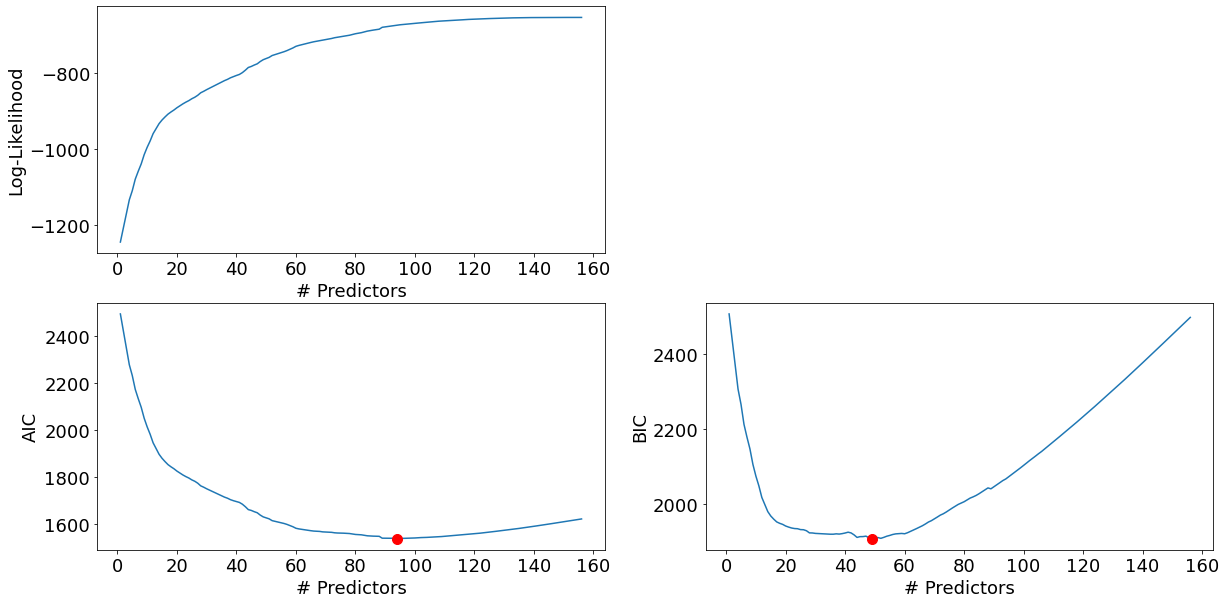

In [102]:
best_sub_plots()

In [103]:
interactions_fwd_reg_model = models_best['logit_model'][50]
interactions_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Attrition_Yes   No. Observations:                 1956
Model:                          Logit   Df Residuals:                     1905
Method:                           MLE   Df Model:                           50
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.4380
Time:                        03:11:51   Log-Likelihood:                -761.96
converged:                       True   LL-Null:                       -1355.8
Covariance Type:            nonrobust   LLR p-value:                7.851e-216
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                    0.5346      0.222      2.410      0.016       0.100       0.969
MaritalStatus_Single_OverTime_Yes                            0.4112      0.288      1.428      0.153      -0.153       0.976
DistanceFromHome_OverTime_Yes                                0.0609      0.015      4.064      0.000       0.032       0.090
DailyRate_JobLevel                                          -0.0006      0.000     -5.641      0.000      -0.001      -0.000
EnvironmentSatisfaction_StockOptionLevel                    -0.2222      0.073     -3.027      0.002      -0.366      -0.078
NumCompaniesWorked_Gender_Male                               0.3312      0.055      6.031      0.000       0.224       0.439
TotalWorkingYears_Gender_Male                               -0.1275      0.020     -6.387      0.000      -0.167      -0.088
StockOptionLevel_OverTime_Yes                                0.7625      0.182      4.186      0.000       0.405       1.119
DailyRate_EducationField_TechnicalDegree                     0.0015      0.000      5.969      0.000       0.001       0.002
RelationshipSatisfaction_JobRole_ResearchScientist          -1.1176      0.152     -7.335      0.000      -1.416      -0.819
EmployeeNumber_BusinessTravel_Travel_Frequently              0.0017      0.000      6.543      0.000       0.001       0.002
YearsInCurrentRole_BusinessTravel_Travel_Frequently         -0.1287      0.069     -1.875      0.061      -0.263       0.006
EmployeeNumber_JobSatisfaction                              -0.0005    7.3e-05     -7.317      0.000      -0.001      -0.000
YearsSinceLastPromotion_Gender_Male                          0.1550      0.053      2.949      0.003       0.052       0.258
JobRole_ResearchScientist_MaritalStatus_Single               3.2478      0.482      6.742      0.000       2.304       4.192
EnvironmentSatisfaction_NumCompaniesWorked                  -0.1279      0.019     -6.711      0.000      -0.165      -0.091
DailyRate_NumCompaniesWorked                                 0.0002    5.2e-05      4.163      0.000       0.000       0.000
EmployeeNumber_EnvironmentSatisfaction                    4.895e-05   5.75e-05      0.852      0.394   -6.37e-05       0.000
YearsSinceLastPromotion_MaritalStatus_Married                0.2160      0.046      4.646      0.000       0.125       0.307
DistanceFromHome_YearsInCurrentRole                         -0.0101      0.002     -4.918      0.000      -0.014      -0.006
DistanceFromHome_MaritalStatus_Single                        0.0372      0.015      2.496      0.013       0.008       0.066
NumCompaniesWorked_OverTime_Yes                              0.1817      0.054      3.388      0.001       0.077       0.287
StockOptionLevel_YearsSinceLastPromotion                    -0.2125      0.038     -5.619      0.000      -0.287    

# Combine the two models

In [323]:
X_no_attrition = train_singular.drop(columns = ["Attrition_Yes"])
X_backup = X_no_attrition.copy()
interactions = pd.DataFrame()

for combo in itertools.combinations(X_backup.columns, 2):
    prefix1 = combo[0][:combo[0].rfind('_')].split('_')[0]
    prefix2 = combo[1][:combo[1].rfind('_')].split('_')[0]
    if prefix1 != prefix2:
        train['_'.join(combo)] = train[combo[0]]*train[combo[1]]
        test['_'.join(combo)] = test[combo[0]]*test[combo[1]]
        X_train_resampled.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)] 
        interactions.loc[:,'_'.join(combo)] = X_train_resampled.loc[:,'_'.join(combo)]
        #only make interaction terms if the prefix(before the last underscore) of combo[0] is not the same as that of of combo[1]
        # Add the other code here under the if condition

In [327]:
train

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_ResearchScientist_MaritalStatus_Single,JobRole_ResearchScientist_OverTime_Yes,JobRole_SalesExecutive_MaritalStatus_Married,JobRole_SalesExecutive_MaritalStatus_Single,JobRole_SalesExecutive_OverTime_Yes,JobRole_SalesRepresentative_MaritalStatus_Married,JobRole_SalesRepresentative_MaritalStatus_Single,JobRole_SalesRepresentative_OverTime_Yes,MaritalStatus_Married_OverTime_Yes,MaritalStatus_Single_OverTime_Yes
0,24,350,21,2,1551,3,57,2,1,1,...,0,0,0,0,0,0,0,0,0,0
1,18,287,5,2,1012,2,73,3,1,4,...,1,0,0,0,0,0,0,0,0,0
2,29,1247,20,2,349,4,45,3,2,4,...,0,0,0,0,0,0,0,0,0,0
3,39,492,12,3,1654,4,66,3,2,2,...,0,0,0,0,0,0,0,0,0,0
4,31,311,20,3,1881,2,89,3,2,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,30,464,4,3,514,3,40,3,1,4,...,1,1,0,0,0,0,0,0,0,1
1952,21,156,12,3,494,3,90,4,1,2,...,0,0,0,0,0,0,1,0,0,0
1953,41,1356,20,2,248,2,70,3,1,2,...,0,0,0,0,0,0,1,1,0,1
1954,23,1243,6,3,811,3,63,4,1,1,...,0,0,0,0,0,0,0,0,1,0


In [343]:
singular_variables = singular_fwd_reg_model.params.keys().to_list()
interaction_variables = interactions_fwd_reg_model.params.keys().to_list()
variables = singular_variables+interaction_variables

In [344]:
names_to_remove = ['WorkLifeBalance_log', 'YearsSinceLastPromotion_quadratic', 'YearsInCurrentRole_quadratic','PercentSalaryHike_log', 'Intercept']

for name in names_to_remove:
    while name in variables:
        variables.remove(name)

In [346]:
formula = 'Attrition_Yes~'+'+'.join(variables)+'+np.log(WorkLifeBalance)+I(YearsSinceLastPromotion**2)+I(YearsInCurrentRole**2)+np.log(PercentSalaryHike)'

In [348]:
final_model = smf.logit(formula = formula, data =train).fit()
final_model.summary()

Optimization terminated successfully.
         Current function value: 0.328414
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Attrition_Yes   No. Observations:                 1956
Model:                          Logit   Df Residuals:                     1876
Method:                           MLE   Df Model:                           79
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.5262
Time:                        10:27:26   Log-Likelihood:                -642.38
converged:                       True   LL-Null:                       -1355.8
Covariance Type:            nonrobust   LLR p-value:                3.400e-246
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                    4.7785      1.524      3.136      0.002       1.792       7.765
OverTime_Yes                                                 1.2184      0.440      2.767      0.006       0.355       2.082
MaritalStatus_Single                                         0.8295      0.463      1.793      0.073      -0.077       1.736
JobLevel                                                     0.2298      0.231      0.996      0.319      -0.222       0.682
JobInvolvement                                              -0.4717      0.110     -4.284      0.000      -0.687      -0.256
JobRole_ResearchScientist                                    1.8578      0.951      1.953      0.051      -0.007       3.722
EducationField_TechnicalDegree                               0.5289      0.628      0.842      0.400      -0.702       1.760
EnvironmentSatisfaction                                     -0.4625      0.159     -2.902      0.004      -0.775      -0.150
JobSatisfaction                                             -1.1611      0.262     -4.427      0.000      -1.675      -0.647
BusinessTravel_Travel_Frequently                             2.4364      0.668      3.646      0.000       1.127       3.746
YearsInCurrentRole                                          -0.2244      0.088     -2.545      0.011      -0.397      -0.052
YearsAtCompany                                               0.1801      0.031      5.746      0.000       0.119       0.242
NumCompaniesWorked                                          -0.0485      0.107     -0.454      0.650      -0.258       0.161
TotalWorkingYears                                           -0.1389      0.029     -4.743      0.000      -0.196      -0.082
DistanceFromHome                                             0.0385      0.024      1.614      0.107      -0.008       0.085
BusinessTravel_Travel_Rarely                                 0.9953      0.318      3.130      0.002       0.372       1.618
MaritalStatus_Married                                       -0.4922      0.542     -0.909      0.363      -1.554       0.569
JobRole_ResearchDirector                                    -2.8491      0.743     -3.834      0.000      -4.305      -1.393
YearsWithCurrManager                                        -0.1219      0.039     -3.131      0.002      -0.198      -0.046
Gender_Male                                                 -1.8694      0.664     -2.814      0.005      -3.171      -0.567
YearsSinceLastPromotion                                      0.2165      0.157      1.378      0.168      -0.091       0.524
JobRole_SalesRepresentative                                  2.4517      0.391      6.270      0.000       1.685       3.218
TrainingTimesLastYear                                       -0.3000      0.230     -1.303      0.192      -0.751    

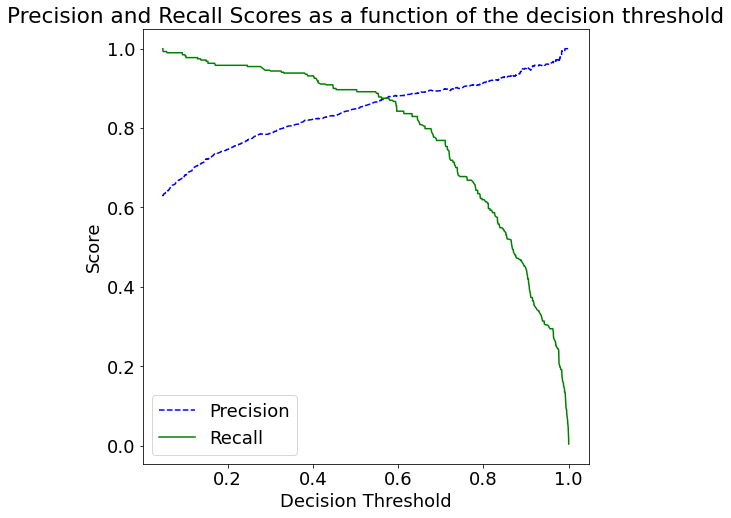

In [354]:
y=train.Attrition_Yes
ypred = final_model.predict(train)
p, r, thresholds = precision_recall_curve(y, ypred)

plot_precision_recall_vs_threshold(p, r, thresholds)

Classification accuracy = 86.5%
Precision = 88.1%
TPR or Recall = 84.3%
FNR = 15.7%
FPR = 11.3%
ROC-AUC = 93.2%


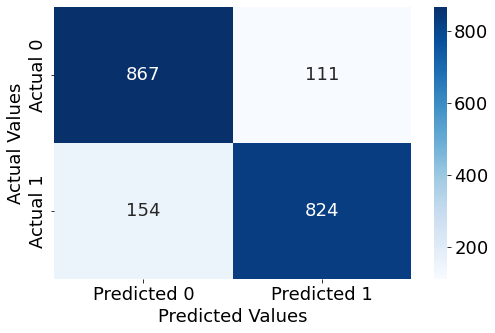

In [355]:
confusion_matrix_data(train,train.Attrition_Yes,final_model,0.6)

Classification accuracy = 78.6%
Precision = 30.0%
TPR or Recall = 46.2%
FNR = 53.8%
FPR = 16.5%
ROC-AUC = 75.9%


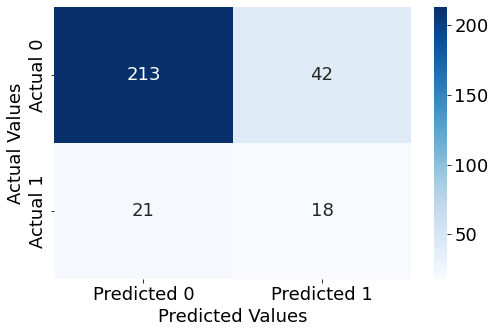

In [358]:
confusion_matrix_data(test,test.Attrition_Yes,final_model,0.6)

0.9317688534256715


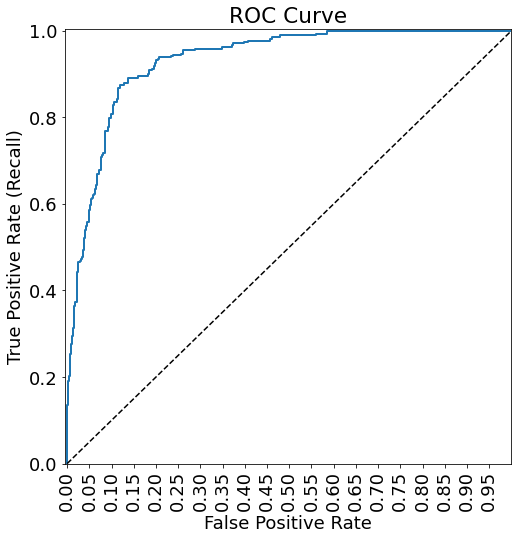

In [361]:
y=train.Attrition_Yes
ypred = final_model.predict(train)
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC

fpr, tpr, auc_thresholds = roc_curve(y, ypred)
plot_roc_curve(fpr, tpr)